## Differentiation anchors tutorial

### A. Preprocessing: Find your trajectories

#### I. Create your eGRN annData object

In [1]:
# Imports
import scanpy as sc
import numpy as np
# Plotting 
import matplotlib
import matplotlib.pyplot as plt
# Inline plotting
%matplotlib inline
# Reset random seed
np.random.seed(5)

In [2]:
# Load data
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/'
import dill
infile = open(outDir+'scplus_obj.pkl', 'rb')
scplus_obj = dill.load(infile)
infile.close()

In [3]:
# Create anndata from AUC matrix (use both gene and region-based cistromes)
import pandas as pd
import anndata
import sklearn
auc_key = 'eRegulon_AUC'
signature_keys = ['Gene_based', 'Region_based']
scale = False
if scale == True:
    data_mat = pd.concat([pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(
            scplus_obj.uns[auc_key][x].T), index=scplus_obj.uns[auc_key][x].T.index.to_list(), columns=scplus_obj.uns[auc_key][x].T.columns) for x in signature_keys])
else:
    data_mat = pd.concat([scplus_obj.uns[auc_key][x].T for x in signature_keys])
selected_regulons = [x for x in data_mat.index if '+_+' in x or '-_+' in x]
data_mat = data_mat.loc[selected_regulons]
adata = anndata.AnnData(X=data_mat.T.copy())
adata.obs = scplus_obj.metadata_cell.copy()

/tmp/ipykernel_16609/1176205227.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(X=data_mat.T.copy())


In [4]:
# Keep only cell types involved in the differentiation trajectory
adata = adata[adata.obs['ACC_VM_ATAC_RM_cell_type'].isin(['AMF_Prec', 'AMF_Prog', 'MF_Morphogenetic_Furrow','PMF_Interommatidial',
 'PMF_Interommatidial_Late','PMF_PR_Early','PMF_PR_Late/CC'])]

In [5]:
# Select variable eGRNs
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=200)

/opt/venv/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


#### II. Find your trajectory with PAGA

In [6]:
# Reanalyze this subset of cells
# Make PCA
sc.tl.pca(adata)
# Make diffusion map
print('DiffMap')
sc.pp.neighbors(adata)
sc.tl.diffmap(adata, random_state=5)
# Make umap
print('Umap')
sc.tl.umap(adata)
# Make tsne
print('TSNE')
sc.tl.tsne(adata)
# Make graph
print('Graph')
sc.tl.draw_graph(adata)

DiffMap
Umap
TSNE
Graph


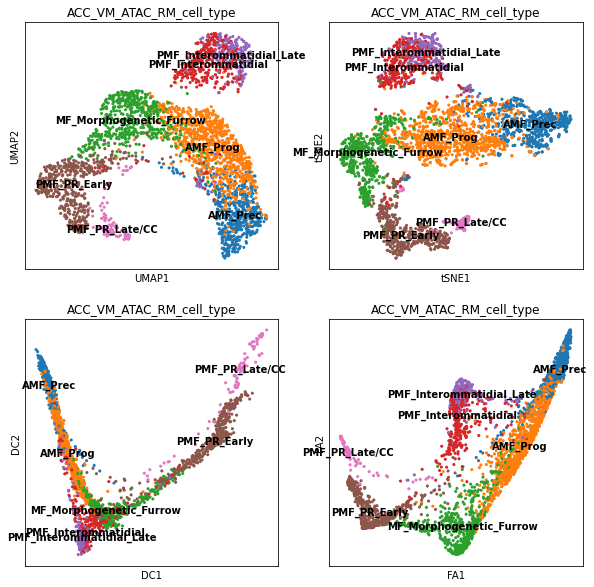

In [8]:
# Visualize
import matplotlib.pyplot as plt
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1_dict = sc.pl.umap(adata, color='ACC_VM_ATAC_RM_cell_type', legend_loc='on data', ax=ax1, show=False)
ax2_dict = sc.pl.tsne(adata, color='ACC_VM_ATAC_RM_cell_type', legend_loc='on data', ax=ax2, show=False)
ax3_dict = sc.pl.diffmap(adata, color='ACC_VM_ATAC_RM_cell_type', legend_loc='on data', ax=ax3, show=False)
ax4_dict = sc.pl.draw_graph(adata, color='ACC_VM_ATAC_RM_cell_type', legend_loc='on data', ax=ax4, show=False)

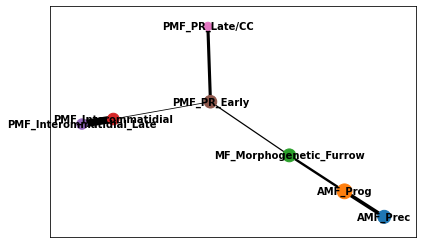

In [9]:
# Run PAGA
sc.tl.paga(adata, groups='ACC_VM_ATAC_RM_cell_type')
%matplotlib inline
sc.pl.paga(adata, threshold=0.1, color='ACC_VM_ATAC_RM_cell_type')

In [10]:
# Redo UMAP using PAGA map
sc.tl.umap(adata, init_pos='paga')

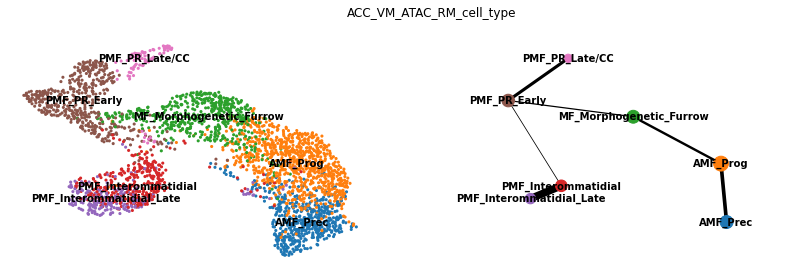

In [11]:
# Visualize. We see that paths split in PR_Early, but this is not true, it is due to the broas definition of cell types (it should be MF or SMW)
sc.tl.paga(adata, groups='ACC_VM_ATAC_RM_cell_type')
sc.pl.paga_compare(adata, basis='umap', threshold=0.1)

In [12]:
adata.obs = adata.obs.iloc[:,0:63] # To avoid weird error about a column
adata.write_h5ad('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/differenrentiation_tutorial_1.h5ad')

#### III. Refine annotation on Second Mitotic Wave

In [13]:
# To read
import scanpy as sc
adata = sc.read_h5ad('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/differenrentiation_tutorial_1.h5ad')

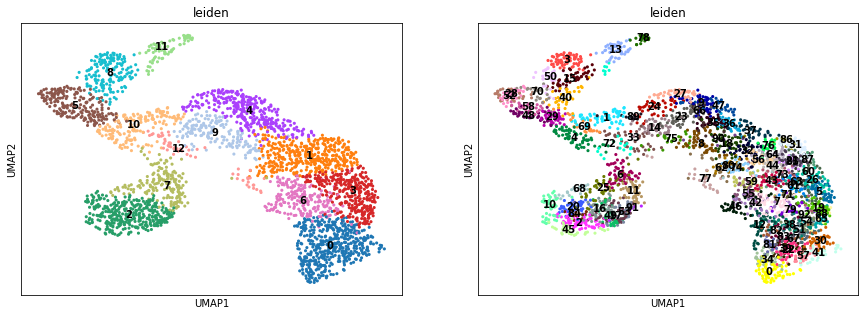

In [14]:
# Rename the division point as SMW.
import matplotlib.pyplot as plt
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,5))
sc.tl.leiden(adata, resolution=1)
ax1_dict = sc.pl.umap(adata, color='leiden', legend_loc='on data', ax=ax1, show=False)
sc.tl.leiden(adata, resolution=10)
ax2_dict = sc.pl.umap(adata, color='leiden', legend_loc='on data', ax=ax2, show=False)

In [15]:
# Broad annotation
sc.tl.leiden(adata, resolution=1)
adata.obs['Diff_state'] = adata.obs['leiden'].astype(str)
adata.obs.loc[adata.obs['leiden'] == '0','Diff_state'] = 'AMF_Prog'
adata.obs.loc[adata.obs['leiden'] == '3','Diff_state'] = 'AMF_Prog'
adata.obs.loc[adata.obs['leiden'] == '6','Diff_state'] = 'AMF_Prog'
adata.obs.loc[adata.obs['leiden'] == '1','Diff_state'] = 'AMF_Prec'
adata.obs.loc[adata.obs['leiden'] == '10','Diff_state'] = 'SMW'
adata.obs.loc[adata.obs['leiden'] == '4','Diff_state'] = 'MF_Morphogenetic_Furrow'
adata.obs.loc[adata.obs['leiden'] == '9','Diff_state'] = 'MF_Morphogenetic_Furrow'
adata.obs.loc[adata.obs['leiden'] == '12','Diff_state'] = 'MF_Morphogenetic_Furrow'
adata.obs.loc[adata.obs['leiden'] == '5','Diff_state'] = 'PMF_PR_Early'
adata.obs.loc[adata.obs['leiden'] == '8','Diff_state'] = 'PMF_PR_Intermediate'
adata.obs.loc[adata.obs['leiden'] == '11','Diff_state'] = 'PMF_PR_Late'
adata.obs.loc[adata.obs['leiden'] == '7','Diff_state'] = 'PMF_Interommatidial'
adata.obs.loc[adata.obs['leiden'] == '2','Diff_state'] = 'PMF_Interommatidial_Late'
# Refine
sc.tl.leiden(adata, resolution=10)
adata.obs['Diff_state'] = adata.obs['Diff_state'].astype(str)
adata.obs.loc[adata.obs['leiden'] == '1','Diff_state'] = 'SMW'
adata.obs.loc[adata.obs['leiden'] == '72','Diff_state'] = 'SMW'
adata.obs.loc[adata.obs['leiden'] == '33','Diff_state'] = 'SMW'
adata.obs.loc[adata.obs['leiden'] == '77','Diff_state'] = 'AMF_Prec'
adata.obs.loc[adata.obs['leiden'] == '46','Diff_state'] = 'AMF_Prog'
sc.tl.leiden(adata, resolution=1)
adata.obs.loc[adata.obs['leiden'] == '10','Diff_state'] = 'SMW'
adata.obs.loc[adata.obs['leiden'] == '11','Diff_state'] = 'PMF_PR_Late'

In [16]:
# Subdividing SMW for PR and INT
sc.tl.leiden(adata, resolution=1)
adata.obs['Diff_state_refined'] = adata.obs['Diff_state'].astype(str)
adata.obs.loc[adata.obs['leiden'] == '10','Diff_state_refined'] = 'SMW_PR'
adata.obs.loc[adata.obs['leiden'] == '11','Diff_state_refined'] = 'PMF_PR_Late'
sc.tl.leiden(adata, resolution=10)
adata.obs['Diff_state_refined'] = adata.obs['Diff_state_refined'].astype(str)
adata.obs.loc[adata.obs['leiden'] == '1','Diff_state_refined'] = 'SMW_PR'
adata.obs.loc[adata.obs['leiden'] == '72','Diff_state_refined'] = 'SMW_INT'
adata.obs.loc[adata.obs['leiden'] == '33','Diff_state_refined'] = 'SMW_INT'
adata.obs.loc[adata.obs['leiden'] == '77','Diff_state_refined'] = 'AMF_Prec'
adata.obs.loc[adata.obs['leiden'] == '46','Diff_state_refined'] = 'AMF_Prog'
sc.tl.leiden(adata, resolution=1)
adata.obs.loc[adata.obs['leiden'] == '11','Diff_state_refined'] = 'PMF_PR_Late'

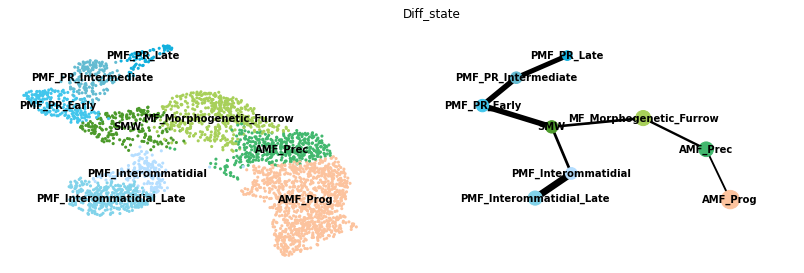

In [7]:
# PAGA graph with broad annotation. Looks good!
import os
os.chdir('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/')
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sc.tl.paga(adata, groups='Diff_state')
sc.pl.paga_compare(adata, basis='umap', threshold=0.245, palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save='paga.pdf')

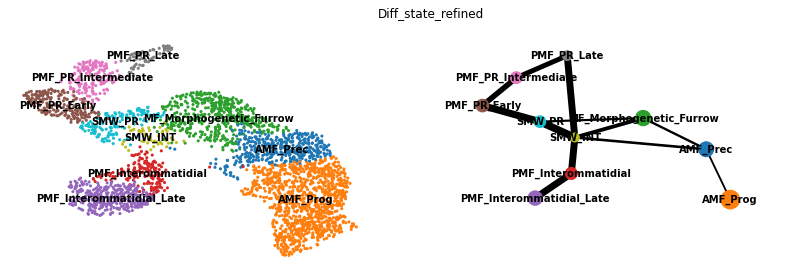

In [18]:
# PAGA graph with refined annotation. A bit more messy.
sc.tl.paga(adata, groups='Diff_state_refined')
sc.pl.paga_compare(adata, basis='umap', threshold=0.245)

In [19]:
adata.write_h5ad('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/differenrentiation_tutorial_2.h5ad')

#### IV. Add gene expression to anndata

In [1]:
# To read
import scanpy as sc
adata = sc.read_h5ad('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/differenrentiation_tutorial_2.h5ad')

In [21]:
# Needed for TF expression
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/'
import dill
infile = open(outDir+'scplus_obj.pkl', 'rb')
scplus_obj = dill.load(infile)
infile.close()

In [22]:
import pandas as pd
import anndata
import sklearn
adata_gene = anndata.AnnData(X=scplus_obj.to_df('EXP').copy())
sc.pp.normalize_total(adata_gene, target_sum=1e4)
sc.pp.log1p(adata_gene)
import scanpy as sc, anndata as ad, numpy as np, pandas as pd
adata_all = ad.concat([adata, adata_gene], axis=1, merge='unique', uns_merge='unique').copy()

In [23]:
# Save
adata_all.write_h5ad('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/differenrentiation_tutorial_3.h5ad')

#### V. Add embedding-based pseudotime

In [1]:
# To read
import scanpy as sc
adata = sc.read_h5ad('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/differenrentiation_tutorial_3.h5ad')

/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


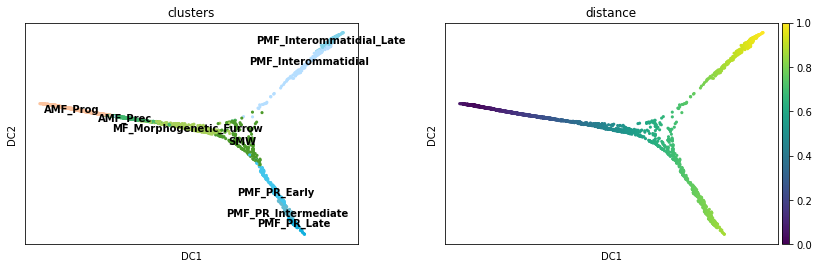

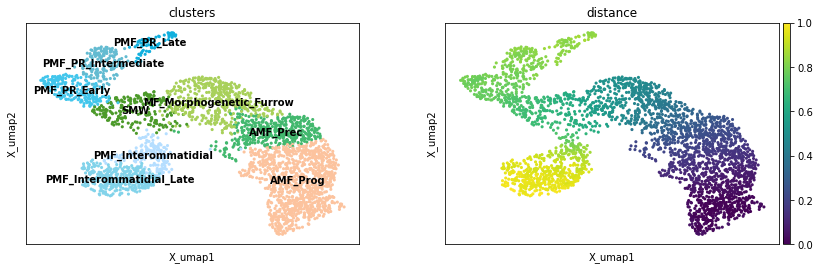

In [9]:
# Choose the embedding you want to plot arrows in. Here I will use the refined annotation because it separates better the branches in the diffusion map.
# The function will already save the annotations as clusters and distance, which are require for downstream steps.
from scenicplus.differentiation_potential import *
def get_embedding_dpt(adata, group_var, root_group, embedding_key='X_umap', n_dcs=2, figsize=(12,8), save_dpt=None, save_pl=None, palette=None):
    adata_h = anndata.AnnData(X=pd.DataFrame(adata.obsm[embedding_key], index=adata.obs.index))
    adata_h.obs = adata.obs.copy()
    sc.pp.neighbors(adata_h)
    adata_h.obs['clusters'] = adata_h.obs[group_var] 
    sc.tl.diffmap(adata_h, random_state=5)
    adata_h.uns['iroot'] = np.flatnonzero(adata_h.obs[group_var]  == root_group)[0]
    sc.tl.dpt(adata_h, n_dcs=n_dcs)
    adata_h.obs['distance'] = adata_h.obs['dpt_pseudotime']
    sc.pl.diffmap(adata_h, color=['clusters', 'distance'], legend_loc='on data', projection='2d', save=save_dpt, palette=palette)
    adata.obs['dpt_pseudotime'] = adata_h.obs['dpt_pseudotime'].copy()
    adata.obs['distance'] = adata.obs['dpt_pseudotime']
    adata.obs['clusters'] = adata.obs[group_var] 
    sc.pl.embedding(adata, embedding_key, color=['clusters', 'distance'], legend_loc='on data', cmap='viridis', save=save_pl, palette=palette)
get_embedding_dpt(adata, 'Diff_state', 'AMF_Prog', embedding_key='X_umap', n_dcs=2, figsize=(12,8), save_dpt='diffmap.pdf', save_pl='umap.pdf', palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
})

In [27]:
# Save
adata.write_h5ad('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/differenrentiation_tutorial_4.h5ad')

### B. Inferring differentiation arrows

In [1]:
# To read
import scanpy as sc
adata = sc.read_h5ad('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/differenrentiation_tutorial_4.h5ad')

In [2]:
adata

AnnData object with n_obs × n_vars = 3104 × 9456
    obs: 'EXP_VM_RNA_x', 'EXP_VM_RNA_y', 'EXP_VM_RNA_R', 'EXP_VM_RNA_G', 'EXP_VM_RNA_B', 'EXP_VM_RNA_cluster', 'EXP_VM_RNA_cluster_color', 'EXP_VM_RNA_cluster_refined', 'EXP_VM_RNA_cluster_refined_color', 'EXP_VM_RNA_cluster_annot', 'EXP_VM_RNA_is.landmark', 'EXP_VM_RNA_RM_assignment', 'EXP_VM_RNA_RM_cell_type', 'EXP_VM_RNA_RM_landmark', 'EXP_VM_RNA_RM_pseudotime', 'EXP_VM_RNA_RM_posLandmark', 'EXP_VM_RNA_RM_spatial_cluster', 'EXP_VM_RNA_DistanceFromLandmark', 'EXP_VM_RNA_PseudotimeRank', 'EXP_VM_cell_name', 'EXP_Seurat_res_1.2', 'EXP_Experiment Run', 'EXP_Ariss labels', 'EXP_ATAC labels', 'EXP_RNA_cell_barcode', 'ACC_VM_ATAC_x', 'ACC_VM_ATAC_y', 'ACC_VM_ATAC_R', 'ACC_VM_ATAC_G', 'ACC_VM_ATAC_B', 'ACC_VM_ATAC_cluster', 'ACC_VM_ATAC_cluster_color', 'ACC_VM_ATAC_cluster_refined', 'ACC_VM_ATAC_cluster_refined_color', 'ACC_VM_ATAC_cluster_annot', 'ACC_VM_ATAC_is.landmark', 'ACC_VM_ATAC_RM_assignment', 'ACC_VM_ATAC_RM_cell_type', 'ACC_VM_ATAC

In [35]:
# Set paths
paths = [('PR', ['AMF_Prog', 'AMF_Prec', 'MF_Morphogenetic_Furrow', 'SMW_PR', 'PMF_PR_Early', 'PMF_PR_Intermediate', 'PMF_PR_Late']),
         ('INT', ['AMF_Prog', 'AMF_Prec', 'MF_Morphogenetic_Furrow', 'SMW_INT', 'PMF_Interommatidial', 'PMF_Interommatidial_Late'])]

In [36]:
# Calculate path matrices
## Select path features
import os
selected_features = {}
selected_features['TF'] = list(set([x.split('_')[0] for x in adata.var.index.tolist() if 'g)' in x]))
selected_features['Region'] = [x for x in adata.var.index.tolist() if 'r)' in x]
selected_features['Gene'] = [x for x in adata.var.index.tolist() if 'g)' in x]
## Calculate
os.chdir('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/scenicplus/src/scenicplus')
from differentiation_potential import *
paths_cascade = {'TF':{}, 'Region':{}, 'Gene':{}}
for x in paths_cascade.keys():
    for ipath, (descr, path) in enumerate(paths):
        mat= get_path_matrix(
                adata, dpt_var = 'distance',
                path_var = 'clusters',
                path = path, features = selected_features[x],
                split_groups = True)
        paths_cascade[x][descr] = mat

In [37]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
def plot_map(adata, paths_cascade, tf, color_var, embedding_key = 'X_umap', window=1,
             plot_type='tf_to_gene', gam_smooth = True, use_ranked_dpt = False, tf_traj_thr=0.7, tf_expr_thr=0.2, penalization = 0.03, n_grid_cols = 50,
             n_grid_rows = 50, n_neighbors = 10, offset_frac = 0.1, scale=100, n_cpu = 1,
             figsize =(10, 10), colormap = cm.Greys, plot_streamplot=True, vmax_streamplot=0.25, linewidth_streamplot=0.5, arrowsize_streamplot=2, density_streamplot=10, return_data = False, save=None, **kwargs):
    tf_name = tf.split('_')[0]
    ke = list(paths_cascade[list(paths_cascade.keys())[0]].keys())
    u_list = []
    v_list = []
    x_list = []
    y_list = []
    tf_expr_list = []
    for k in ke:
        df = plot_potential(adata, paths_cascade, k, tf, window=window, return_data=True, show_plot=False, gam_smooth=gam_smooth, use_ranked_dpt = use_ranked_dpt) 
        arrow_map = calculate_arrows(df, penalization)
        embedding = pd.DataFrame(adata.obsm[embedding_key], index=adata.obs.index, columns=['x', 'y'])
        embedding.iloc[:,0] = embedding.iloc[:,0]+abs(min(embedding.iloc[:,0]))
        embedding.iloc[:,1] = embedding.iloc[:,1]+abs(min(embedding.iloc[:,1]))
        embedding = embedding.loc[df.index]
        df = pd.concat([arrow_map, embedding], axis=1)
        df[plot_type+'_match'] =  [df[plot_type+'_match'][i] if not isnan(df[plot_type+'_match'][i]) else df.index[i] for i in range(df.shape[0]) ]
        df[plot_type+'_match'] =  [df[plot_type+'_match'][i] if df.iloc[i,0] > tf_traj_thr else df.index[i] for i in range(df.shape[0]) ]
        df[plot_type+'_match'] =  [df[plot_type+'_match'][i] if df.iloc[i,3] > tf_expr_thr else df.index[i] for i in range(df.shape[0]) ]
        df = df.loc[:,['x', 'y', plot_type+'_match', tf_name+'_all_paths']].dropna()
        x = df.loc[:,'x']
        y = df.loc[:,'y']
        u = np.array(df.loc[df[plot_type+'_match'], 'x'])-np.array(x)
        v = np.array(df.loc[df[plot_type+'_match'], 'y'])-np.array(y)
        tf_expr = np.array(df.iloc[:,3])
        u_list.append(u)
        v_list.append(v)
        x_list.append(x)
        y_list.append(y)
        tf_expr_list.append(tf_expr)
    u = np.concatenate(u_list)
    v = np.concatenate(v_list)
    x = np.concatenate(x_list)
    y = np.concatenate(y_list)
    tf_expr = np.concatenate(tf_expr_list)
    # Plot as grid
    embedding = np.array([x,y]).T
    delta_embedding = np.array([u,v]).T
    grid_xy, uv, mask, color = calculate_grid_arrows(embedding, delta_embedding, tf_expr, offset_frac, n_grid_cols, n_grid_rows, n_neighbors, n_cpu)
    from matplotlib.pyplot import rc_context
    with rc_context({'figure.figsize': figsize}):
        sc.pl.embedding(adata, embedding_key, color=[color_var], zorder=0, return_fig=True, title=tf, **kwargs) 
    if plot_streamplot is True:
        distances = np.sqrt((uv**2).sum(1))
        norm = matplotlib.colors.Normalize(vmin=0, vmax=vmax_streamplot, clip=True)
        mapper = cm.ScalarMappable(norm=norm, cmap=colormap)
        scale = lambda X: [(x - min(X)) / (max(X) - min(X)) for x in X]
        uv[~mask] = np.nan
        plt.streamplot(
                grid_xy.reshape(n_grid_cols,n_grid_cols, 2)[:, :, 0],
                grid_xy.reshape(n_grid_cols,n_grid_cols, 2)[:, :, 1],
                uv.reshape(n_grid_cols,n_grid_cols, 2)[:, :, 0],
                uv.reshape(n_grid_cols,n_grid_cols, 2)[:, :, 1], density = density_streamplot, color = np.array(scale(distances)).reshape(n_grid_cols,n_grid_cols), cmap = colormap, zorder = 1, norm = norm,
                linewidth = linewidth_streamplot, arrowsize=arrowsize_streamplot)
    else:    
        plt.quiver(grid_xy[mask, 0], grid_xy[mask, 1], uv[mask, 0], uv[mask, 1], zorder=1, color=colormap(color[mask]), scale=scale)
    if save is not None:
        plt.savefig(save)
    if return_data == True:
        return df

#### 1. BarH2 (INT and R1-6: http://genesdev.cshlp.org/content/6/1/50.long)

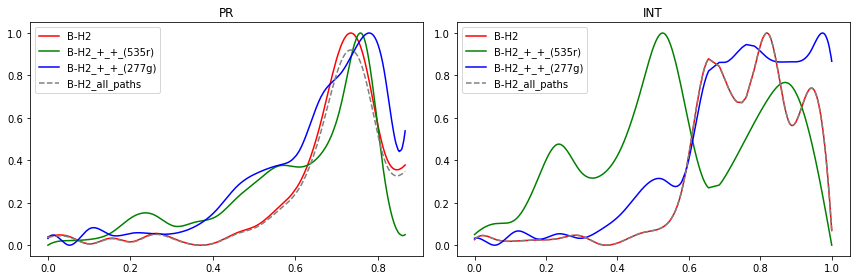

In [38]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'PR', 'B-H2', window=1, gam_smooth=True, return_data = True)
plt.subplot(1, 2, 2)
df_2 = plot_potential(adata, paths_cascade, 'INT', 'B-H2', window=1, gam_smooth=True, return_data = True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/curve_plots/B-H2.pdf')

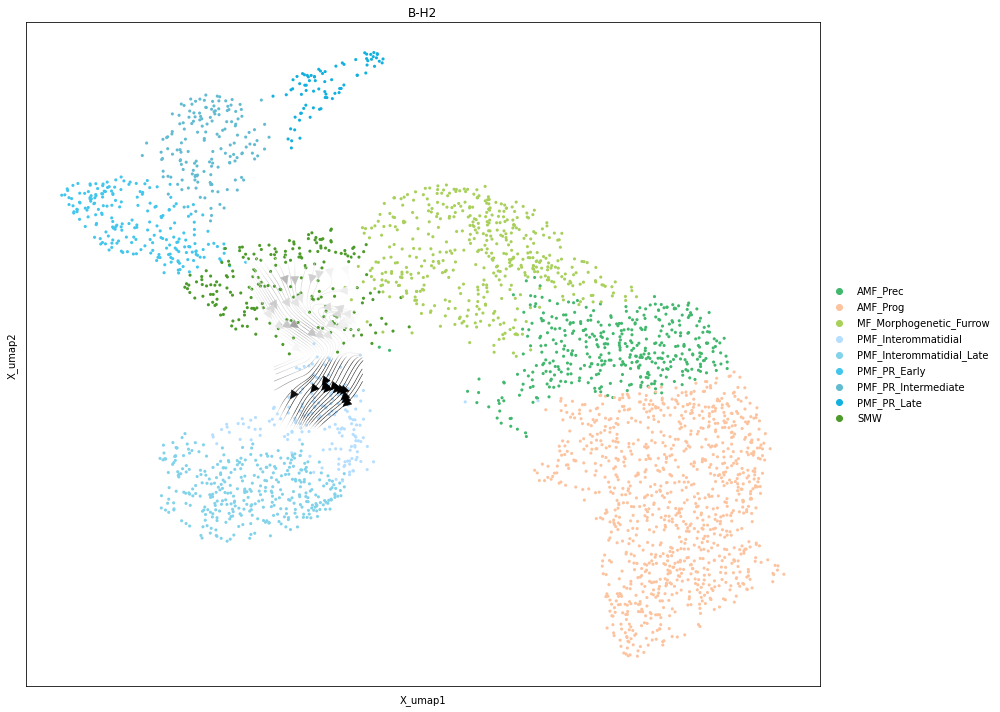

In [39]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'B-H2', color_var='Diff_state', n_grid_cols = 25, n_grid_rows = 25, offset_frac = 0.005,
             tf_traj_thr=0.7, tf_expr_thr=0.2, scale=50, figsize=(14,10), gam_smooth=True, palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/arrow_plots/B-H2.pdf')

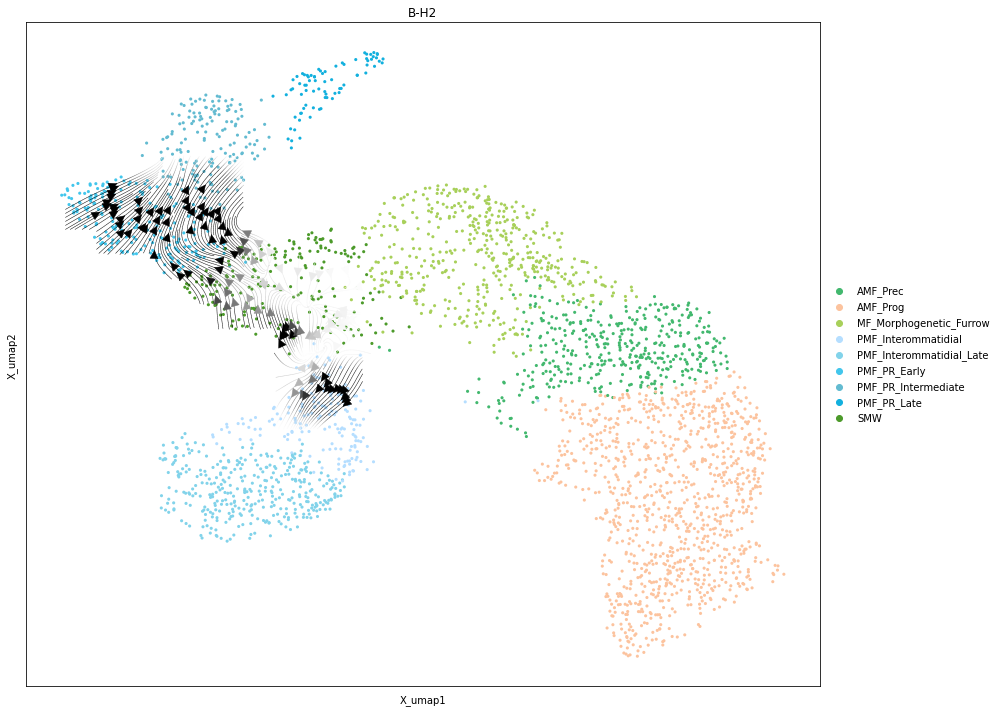

In [40]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'B-H2', color_var='Diff_state', n_grid_cols = 25, n_grid_rows = 25, offset_frac = 0.005,
             tf_traj_thr=0.7, tf_expr_thr=0.2, scale=50, figsize=(14,10), gam_smooth=True, penalization=0.2, palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/arrow_plots/B-H2_less_penal.pdf')

#### 2. BarH1 (INT and R1-6: http://genesdev.cshlp.org/content/6/1/50.long)

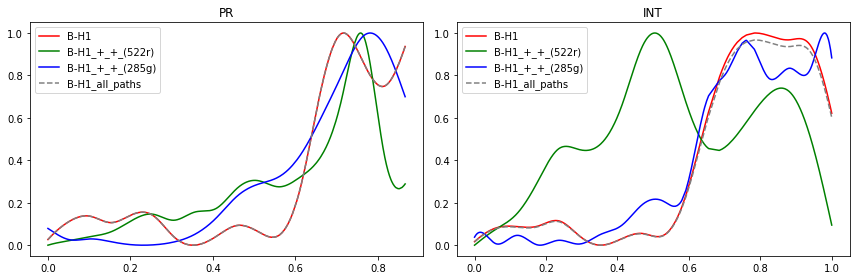

In [41]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'PR', 'B-H1', window=1, gam_smooth=True, return_data = True)
plt.subplot(1, 2, 2)
df_2 = plot_potential(adata, paths_cascade, 'INT', 'B-H1', window=1, gam_smooth=True, return_data = True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/curve_plots/B-H1.pdf')

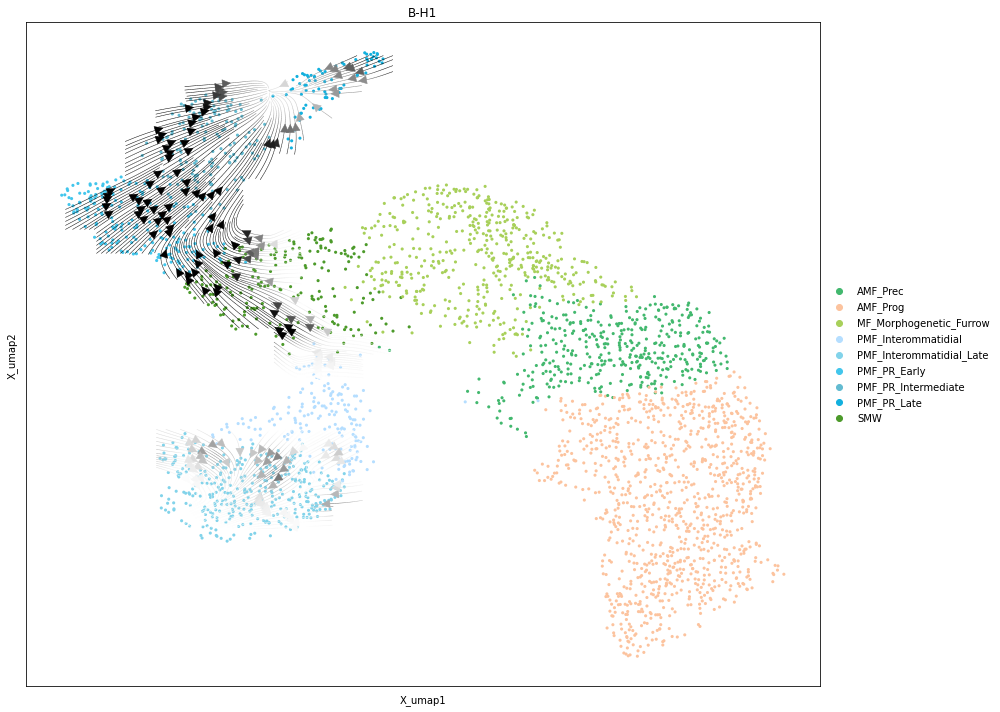

In [42]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'B-H1', color_var='Diff_state', n_grid_cols = 25, n_grid_rows = 25, offset_frac = 0.005,
             tf_traj_thr=0.7, tf_expr_thr=0.2, scale=50, figsize=(14,10), gam_smooth=True, palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/arrow_plots/B-H1.pdf')

#### 3. Glass (PR, and INT?)

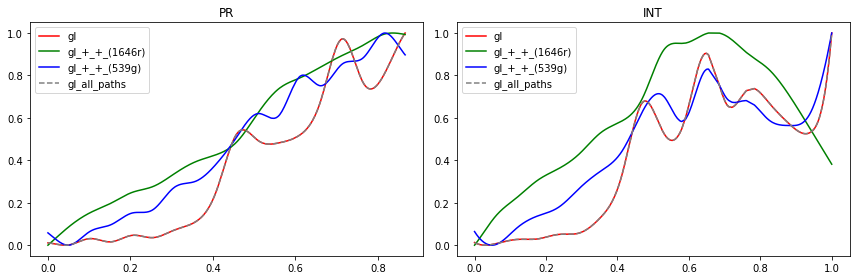

In [43]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'PR', 'gl', window=1, gam_smooth=True, return_data = True)
plt.subplot(1, 2, 2)
df_2 = plot_potential(adata, paths_cascade, 'INT', 'gl', window=1, gam_smooth=True, return_data = True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/curve_plots/gl.pdf')

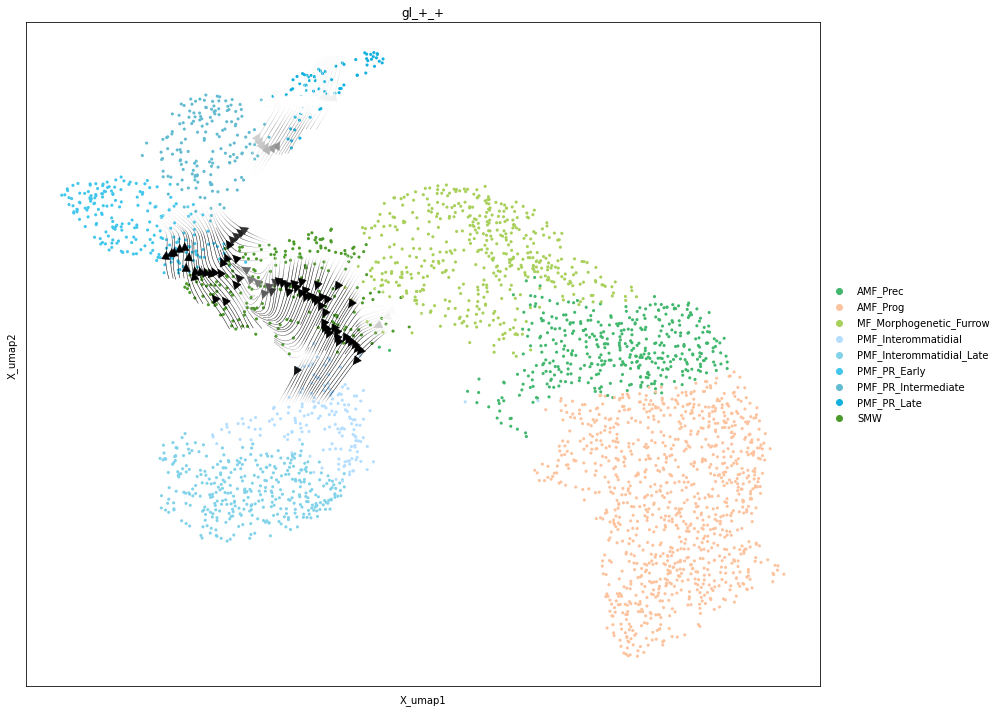

In [44]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'gl_+_+', color_var='Diff_state', n_grid_cols = 25, n_grid_rows = 25, offset_frac = 0.005,
             tf_traj_thr=0.7, tf_expr_thr=0.2, scale=50, figsize=(14,10), gam_smooth=True, penalization=0.5,palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/arrow_plots/gl_+_+.pdf')

#### 4. Ato (MF)

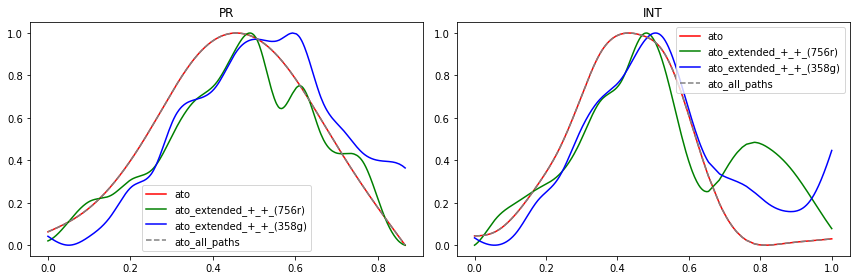

In [45]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'PR', 'ato_extended', window=1, gam_smooth=True, return_data = True)
plt.subplot(1, 2, 2)
df_2 = plot_potential(adata, paths_cascade, 'INT', 'ato_extended', window=1, gam_smooth=True, return_data = True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/curve_plots/ato.pdf')

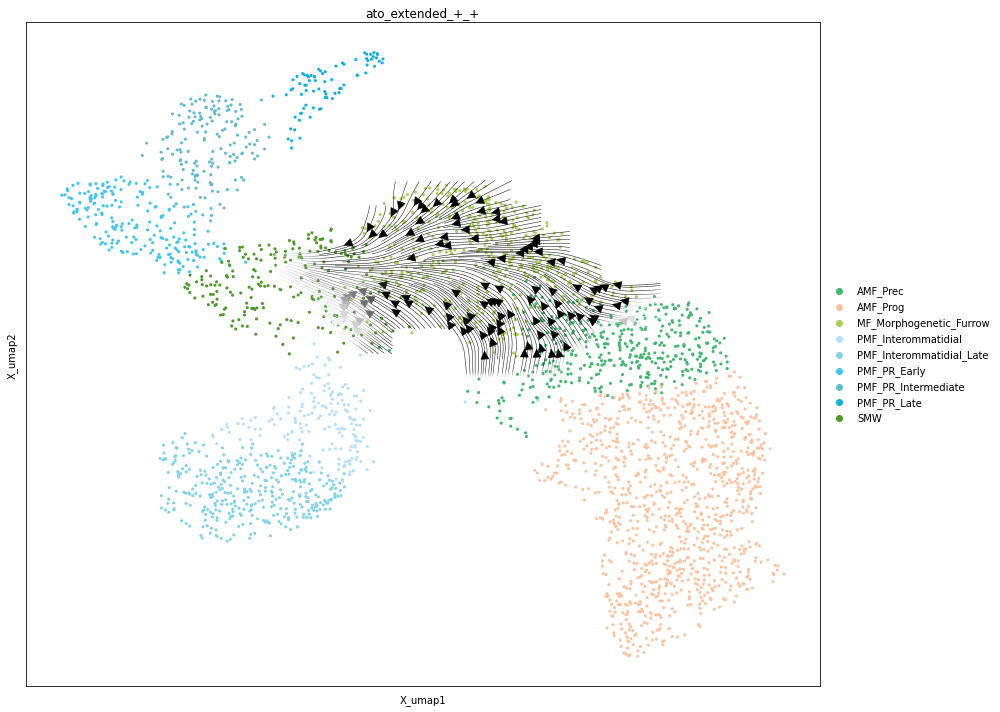

In [46]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'ato_extended_+_+', color_var='Diff_state', n_grid_cols = 25, n_grid_rows = 25, offset_frac = 0.005,
             tf_traj_thr=0.7, tf_expr_thr=0.2, scale=50, figsize=(14,10), gam_smooth=True, penalization=0.5,palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/arrow_plots/ato_+_+.pdf')

#### 5. Lz (INT)

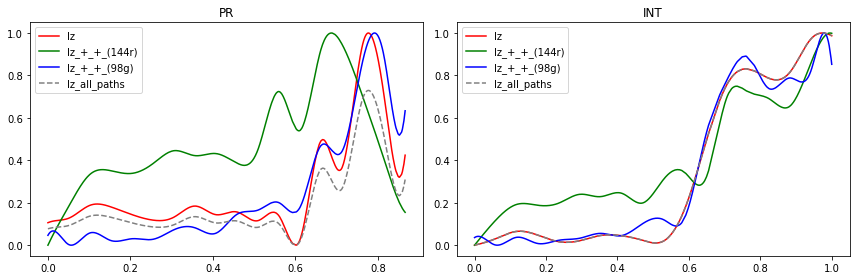

In [47]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'PR', 'lz', window=1, gam_smooth=True, return_data = True)
plt.subplot(1, 2, 2)
df_2 = plot_potential(adata, paths_cascade, 'INT', 'lz', window=1, gam_smooth=True, return_data = True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/curve_plots/lz.pdf')

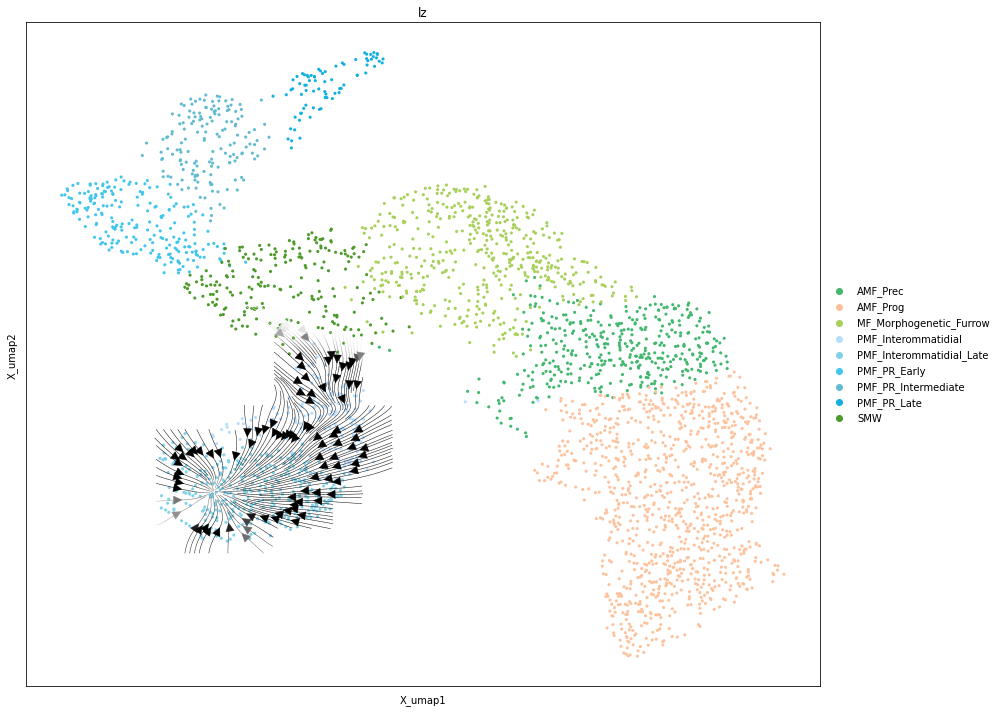

In [49]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'lz', color_var='Diff_state', n_grid_cols = 25, n_grid_rows = 25, offset_frac = 0.005,
             tf_traj_thr=0.7, tf_expr_thr=0.2, scale=50, figsize=(14,10), gam_smooth=True, palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/arrow_plots/lz+.pdf')

#### 6. Lola (PR)

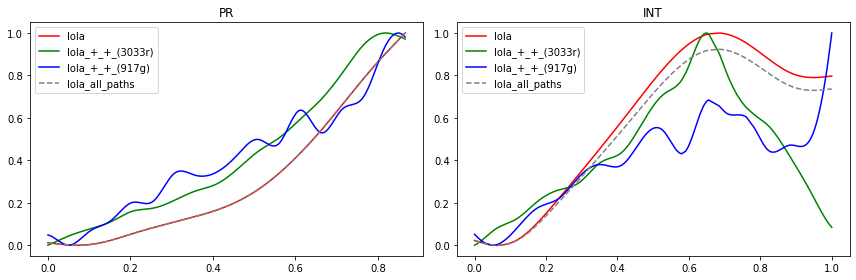

In [50]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'PR', 'lola', window=1, gam_smooth=True, return_data = True)
plt.subplot(1, 2, 2)
df_2 = plot_potential(adata, paths_cascade, 'INT', 'lola', window=1, gam_smooth=True, return_data = True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/curve_plots/lola.pdf')

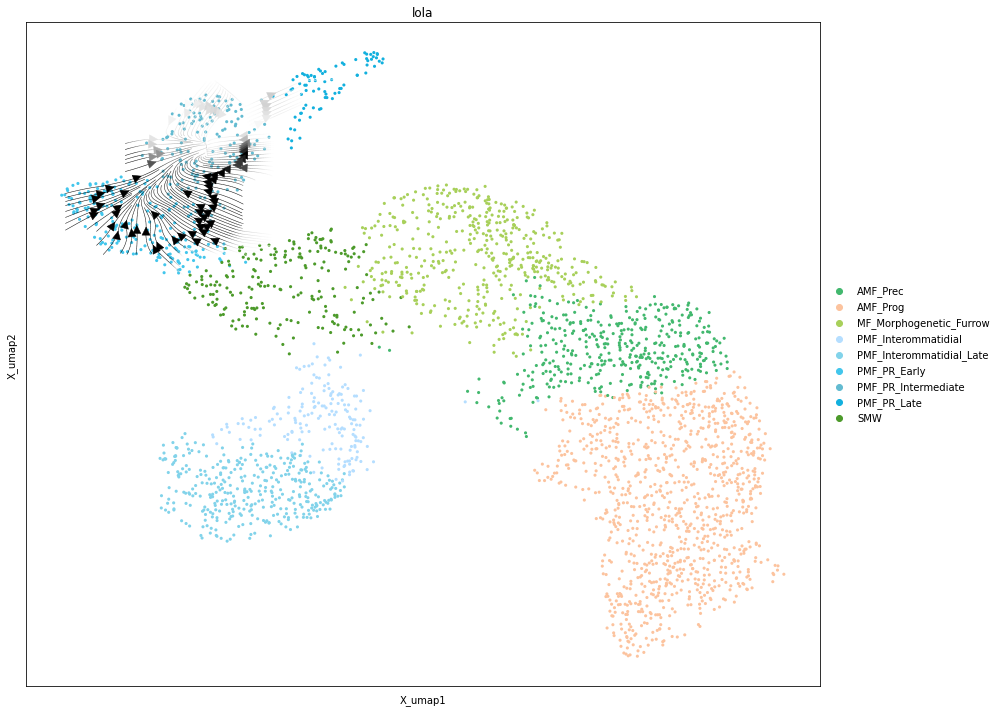

In [51]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'lola', color_var='Diff_state', n_grid_cols = 25, n_grid_rows = 25, offset_frac = 0.005,
             tf_traj_thr=0.7, tf_expr_thr=0.2, scale=50, figsize=(14,10), gam_smooth=True, palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/arrow_plots/lola.pdf')

#### 7. Optix (Progenitors/Precursors)

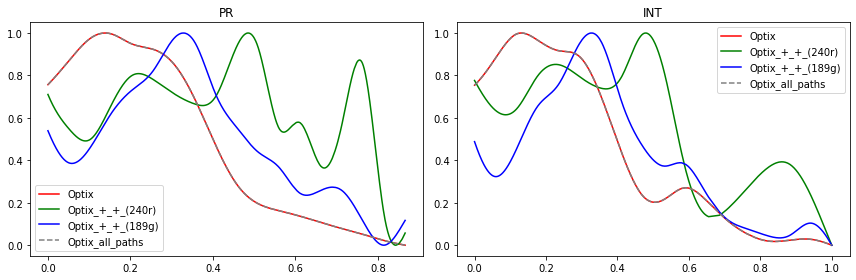

In [52]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'PR', 'Optix', window=1, gam_smooth=True, return_data = True)
plt.subplot(1, 2, 2)
df_2 = plot_potential(adata, paths_cascade, 'INT', 'Optix', window=1, gam_smooth=True, return_data = True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/curve_plots/Optix.pdf')

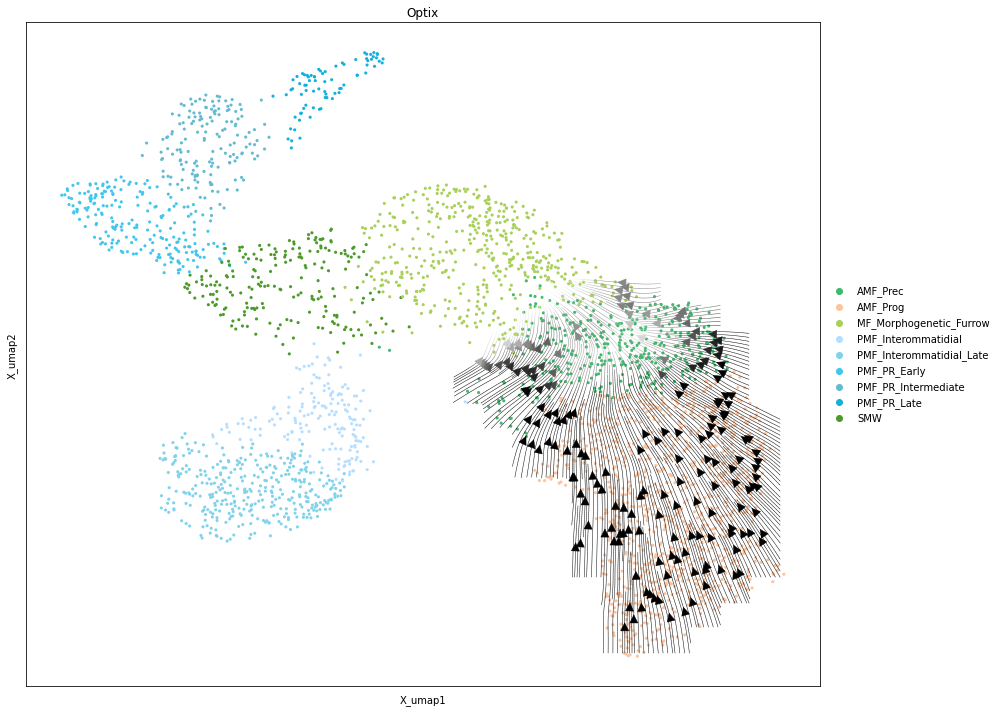

In [72]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Optix', color_var='Diff_state', n_grid_cols = 25, n_grid_rows = 25, offset_frac = 0.005,
             tf_traj_thr=0.7, tf_expr_thr=0.2, scale=50, figsize=(14,10), gam_smooth=True, palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/arrow_plots/Optix_thr_low.pdf')

#### 8. Ase (PR early)

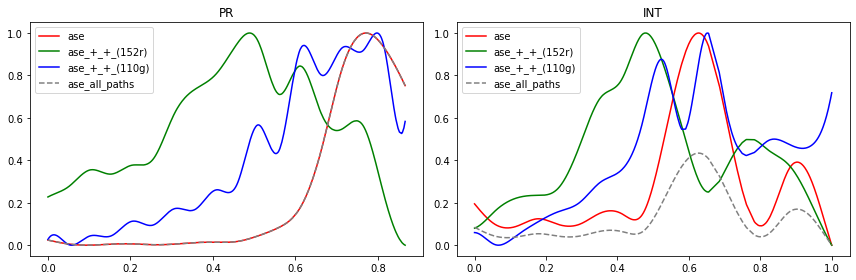

In [54]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'PR', 'ase', window=1, gam_smooth=True, return_data = True)
plt.subplot(1, 2, 2)
df_2 = plot_potential(adata, paths_cascade, 'INT', 'ase', window=1, gam_smooth=True, return_data = True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/curve_plots/ase.pdf')

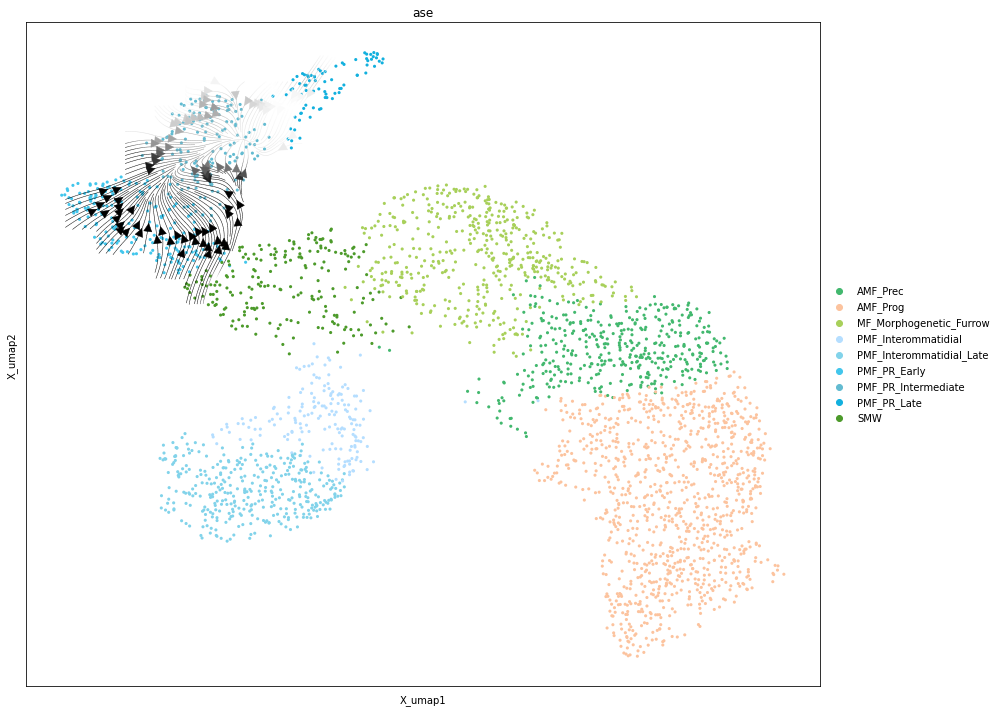

In [55]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'ase', color_var='Diff_state', n_grid_cols = 25, n_grid_rows = 25, offset_frac = 0.005,
             tf_traj_thr=0.8, tf_expr_thr=0.8, scale=50, figsize=(14,10), gam_smooth=True, penalization=0.01, palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/arrow_plots/ase.pdf')

#### 9. Ro (PR early)

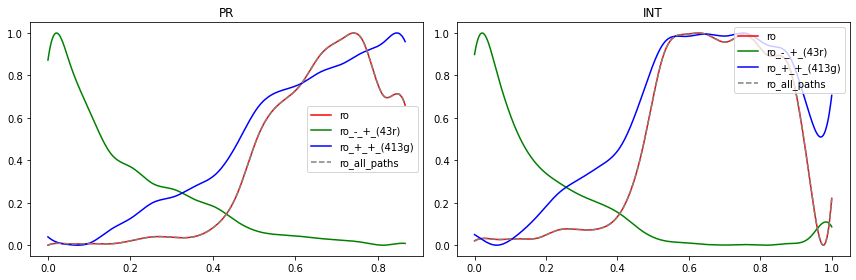

In [56]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'PR', 'ro', window=300, gam_smooth=True, return_data = True)
plt.subplot(1, 2, 2)
df_2 = plot_potential(adata, paths_cascade, 'INT', 'ro', window=300, gam_smooth=True, return_data = True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/curve_plots/ro.pdf')

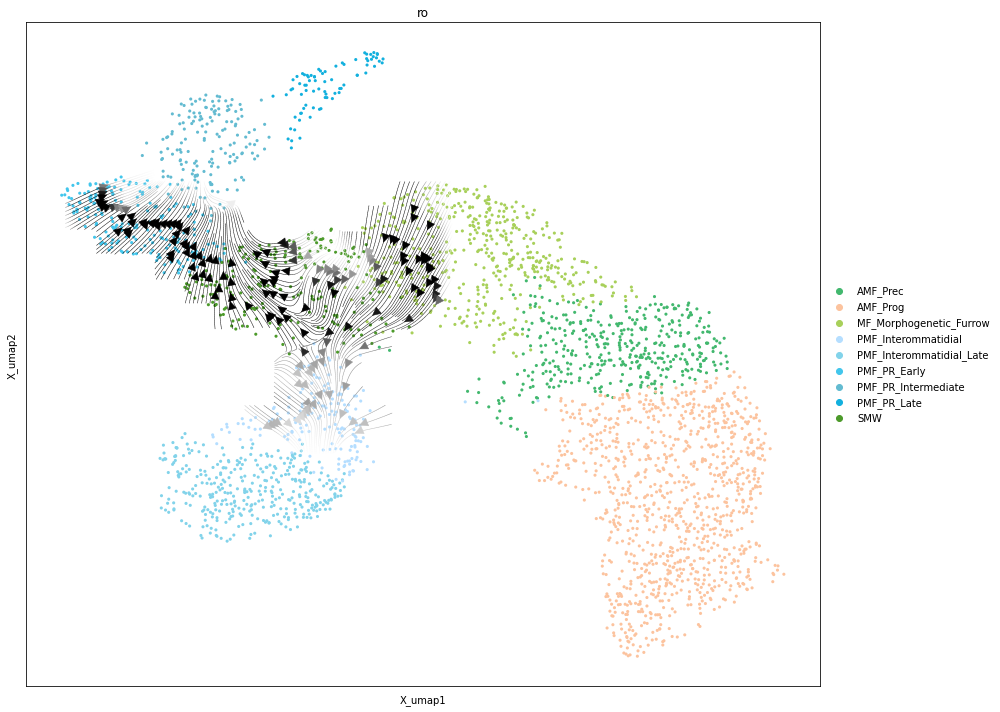

In [57]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'ro', color_var='Diff_state', n_grid_cols = 25, n_grid_rows = 25, offset_frac = 0.005,
             tf_traj_thr=0.7, tf_expr_thr=0.2, scale=50, figsize=(14,10), gam_smooth=True, window=300, palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/arrow_plots/ro.pdf')

#### 10. Onecut (PR late)

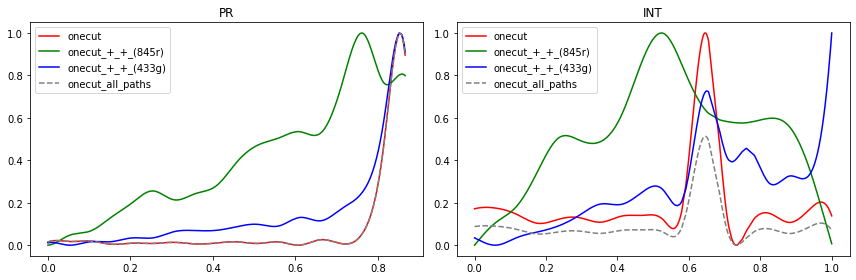

In [58]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'PR', 'onecut', window=1, gam_smooth=True, return_data = True)
plt.subplot(1, 2, 2)
df_2 = plot_potential(adata, paths_cascade, 'INT', 'onecut', window=1, gam_smooth=True, return_data = True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/curve_plots/onecut.pdf')

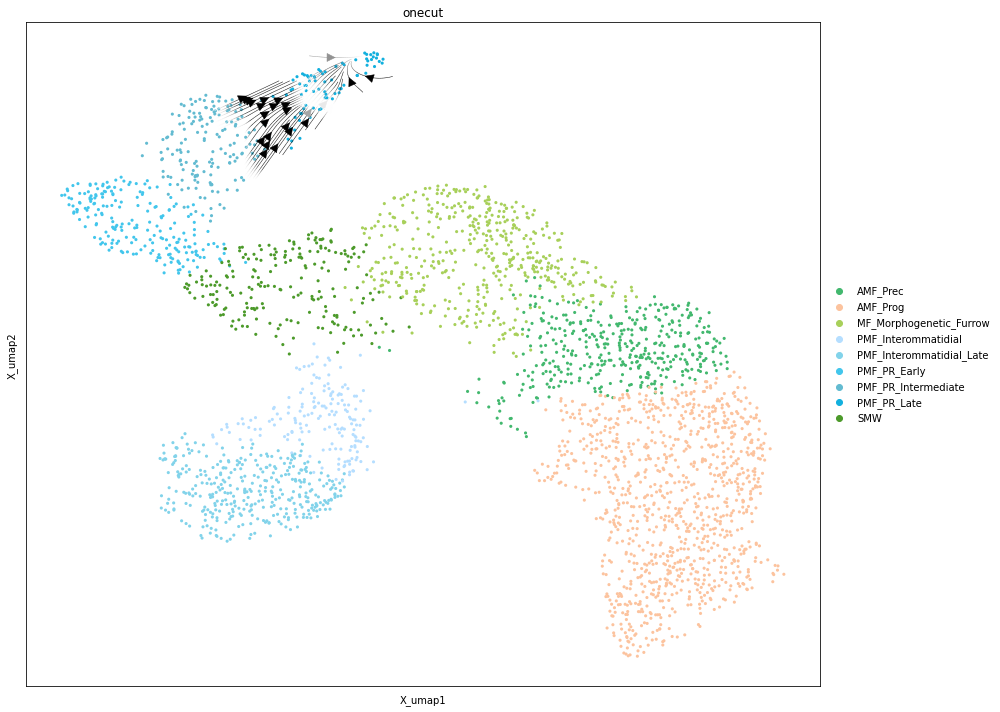

In [59]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'onecut', color_var='Diff_state', n_grid_cols = 25, n_grid_rows = 25, offset_frac = 0.005,
             tf_traj_thr=0.7, tf_expr_thr=0.2, scale=50, figsize=(14,10), gam_smooth=True,  palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/arrow_plots/onecut.pdf')

#### 11. Ey (Precursors)

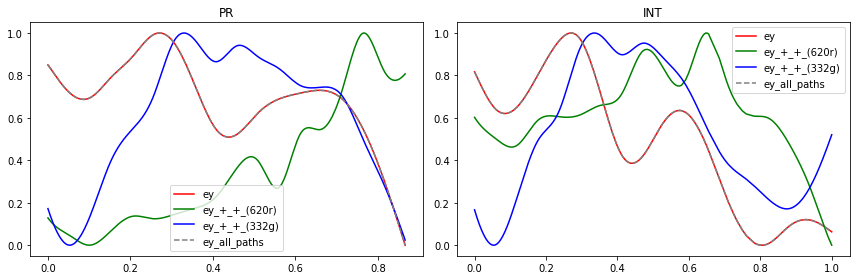

In [60]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'PR', 'ey', window=1, gam_smooth=True, return_data = True)
plt.subplot(1, 2, 2)
df_2 = plot_potential(adata, paths_cascade, 'INT', 'ey', window=1, gam_smooth=True, return_data = True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/curve_plots/ey.pdf')

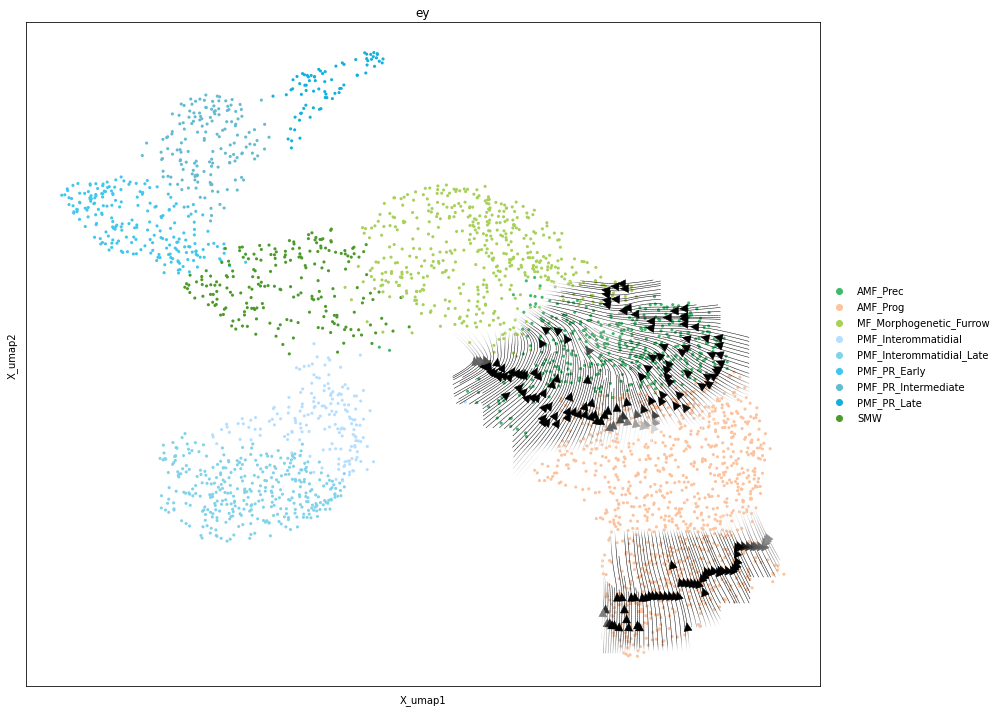

In [74]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'ey', color_var='Diff_state', n_grid_cols = 25, n_grid_rows = 25, offset_frac = 0.005,
             tf_traj_thr=0.8, tf_expr_thr=0.2, scale=50, figsize=(14,10), gam_smooth=True,  palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/arrow_plots/ey_low_thr.pdf')

#### 12. Rn (MF)

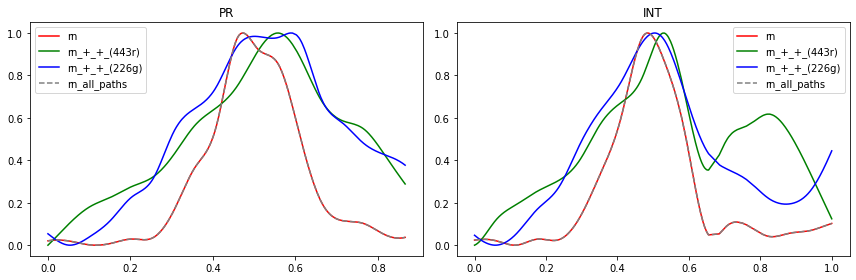

In [62]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'PR', 'rn', window=1, gam_smooth=True, return_data = True)
plt.subplot(1, 2, 2)
df_2 = plot_potential(adata, paths_cascade, 'INT', 'rn', window=1, gam_smooth=True, return_data = True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/curve_plots/rn.pdf')

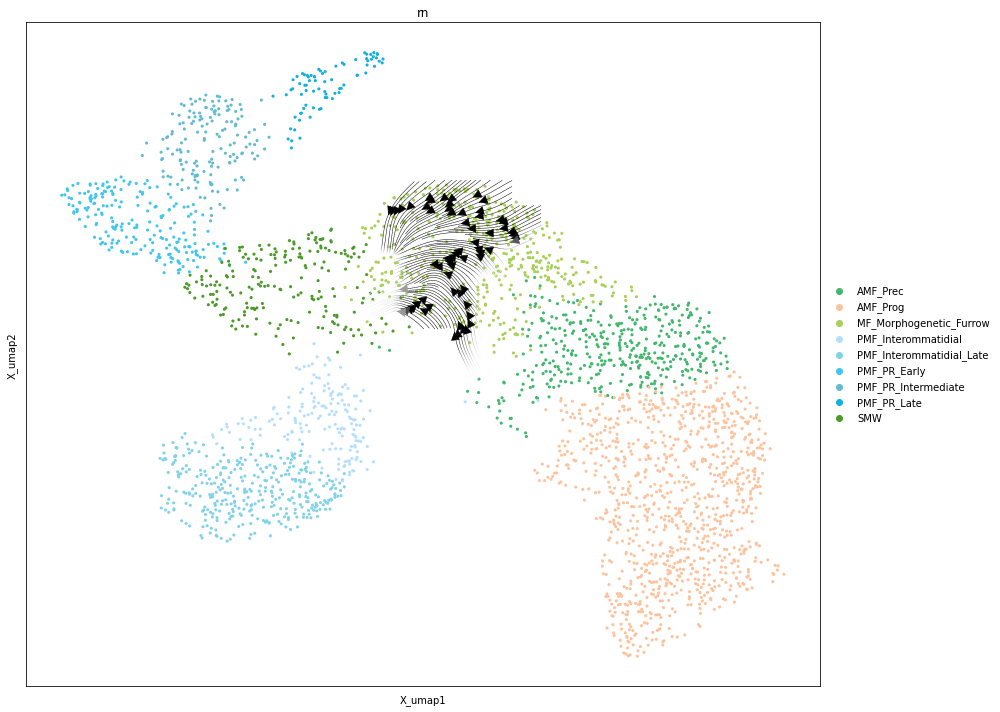

In [63]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'rn', color_var='Diff_state', n_grid_cols = 25, n_grid_rows = 25, offset_frac = 0.005,
             tf_traj_thr=0.9, tf_expr_thr=0.2, scale=50, figsize=(14,10), gam_smooth=True,  palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/arrow_plots/rn.pdf')

#### 13. svp (PR)

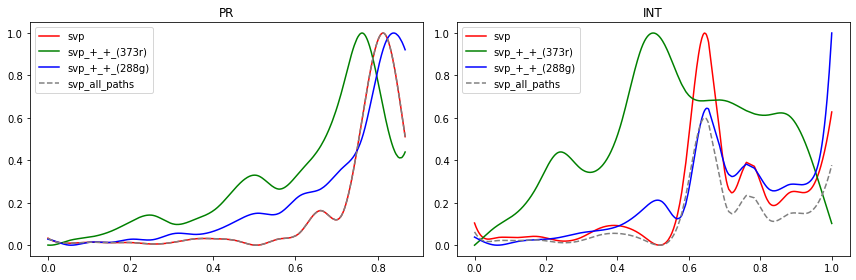

In [64]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'PR', 'svp', window=1, gam_smooth=True, return_data = True)
plt.subplot(1, 2, 2)
df_2 = plot_potential(adata, paths_cascade, 'INT', 'svp', window=1, gam_smooth=True, return_data = True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/curve_plots/svp.pdf')

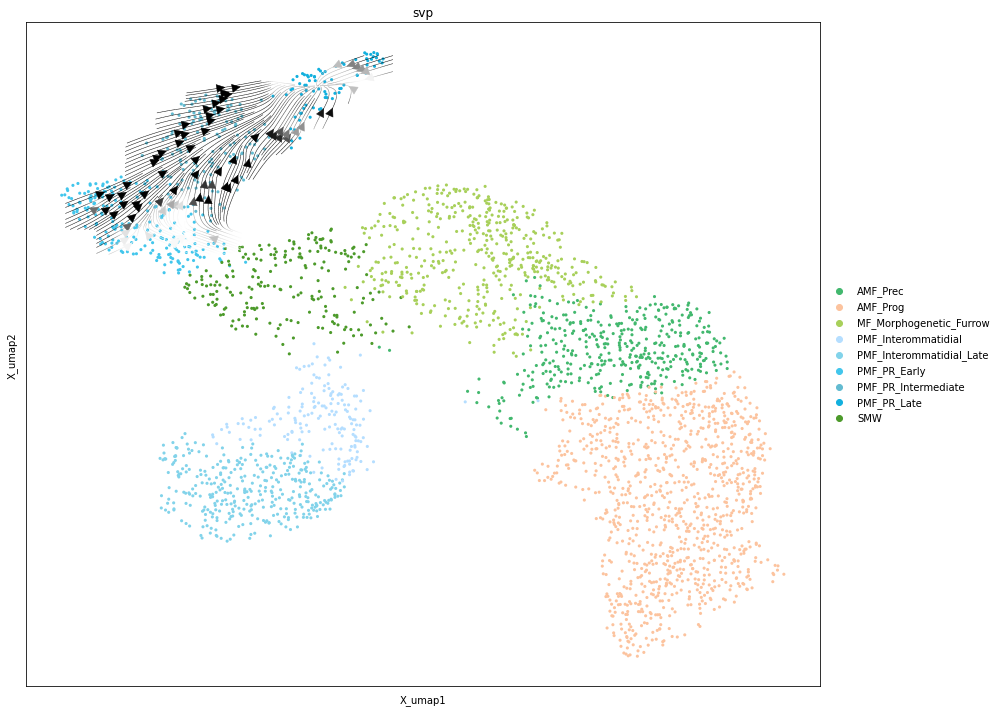

In [65]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'svp', color_var='Diff_state', n_grid_cols = 25, n_grid_rows = 25, offset_frac = 0.005,
             tf_traj_thr=0.7, tf_expr_thr=0.2, scale=50, figsize=(14,10), gam_smooth=True,  palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/arrow_plots/svp.pdf')

#### 14. sens (R8)

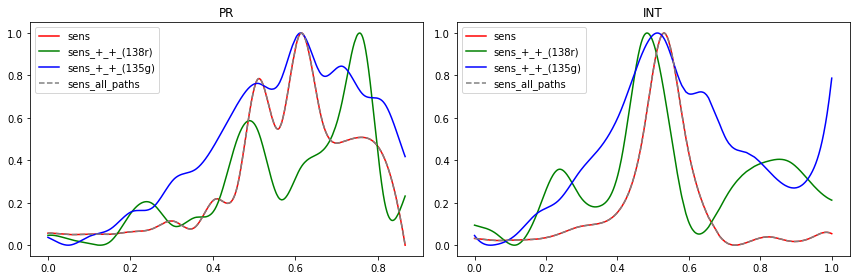

In [67]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'PR', 'sens_+_+', window=1, gam_smooth=True, return_data = True)
plt.subplot(1, 2, 2)
df_2 = plot_potential(adata, paths_cascade, 'INT', 'sens_+_+', window=1, gam_smooth=True, return_data = True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/curve_plots/sens.pdf')

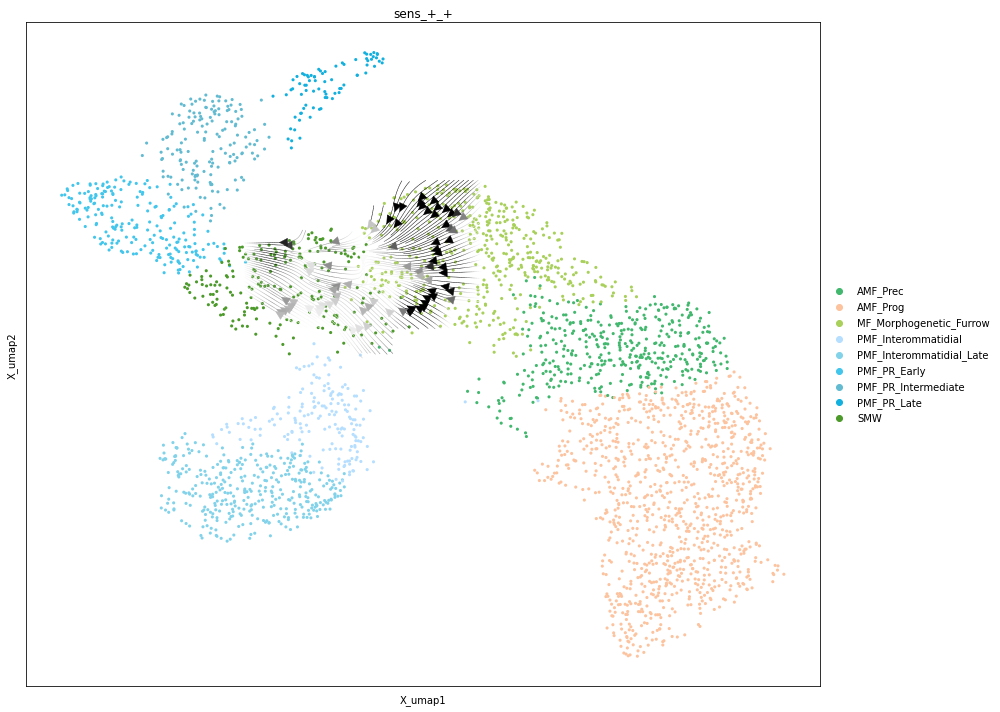

In [68]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'sens_+_+', color_var='Diff_state', n_grid_cols = 25, n_grid_rows = 25, offset_frac = 0.005,
             tf_traj_thr=0.7, tf_expr_thr=0.2, scale=50, figsize=(14,10), gam_smooth=True,  palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/arrow_plots/sens.pdf')

#### 15. Bgb (INT)

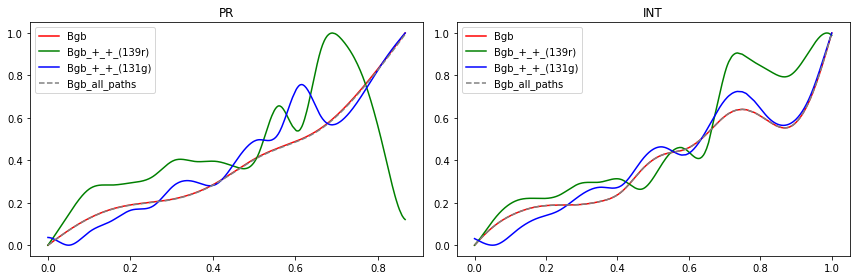

In [69]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'PR', 'Bgb', window=1, gam_smooth=True, return_data = True)
plt.subplot(1, 2, 2)
df_2 = plot_potential(adata, paths_cascade, 'INT', 'Bgb', window=1, gam_smooth=True, return_data = True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/curve_plots/Bgb.pdf')

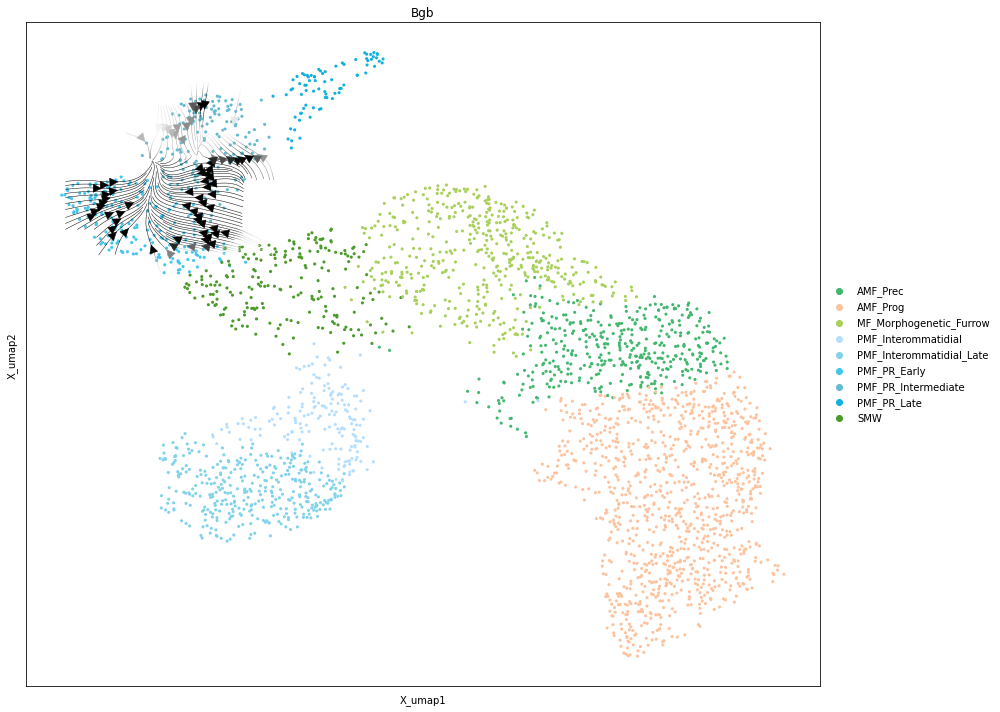

In [70]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Bgb', color_var='Diff_state', n_grid_cols = 25, n_grid_rows = 25, offset_frac = 0.005,
             tf_traj_thr=0.7, tf_expr_thr=0.2, scale=50, figsize=(14,10), gam_smooth=True,  palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/arrow_plots/Bgb.pdf')

## Toy

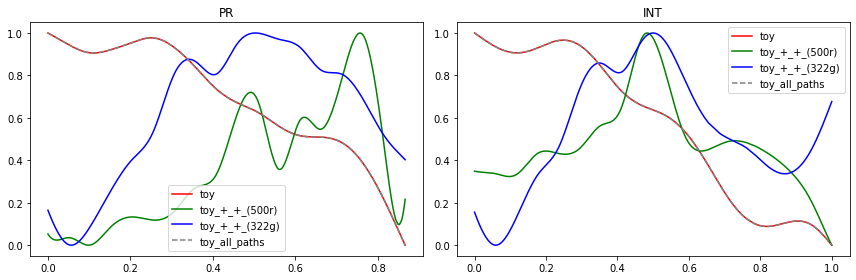

In [76]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'PR', 'toy_+_+', window=1, gam_smooth=True, return_data = True)
plt.subplot(1, 2, 2)
df_2 = plot_potential(adata, paths_cascade, 'INT', 'toy_+_+', window=1, gam_smooth=True, return_data = True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/curve_plots/toy.pdf')

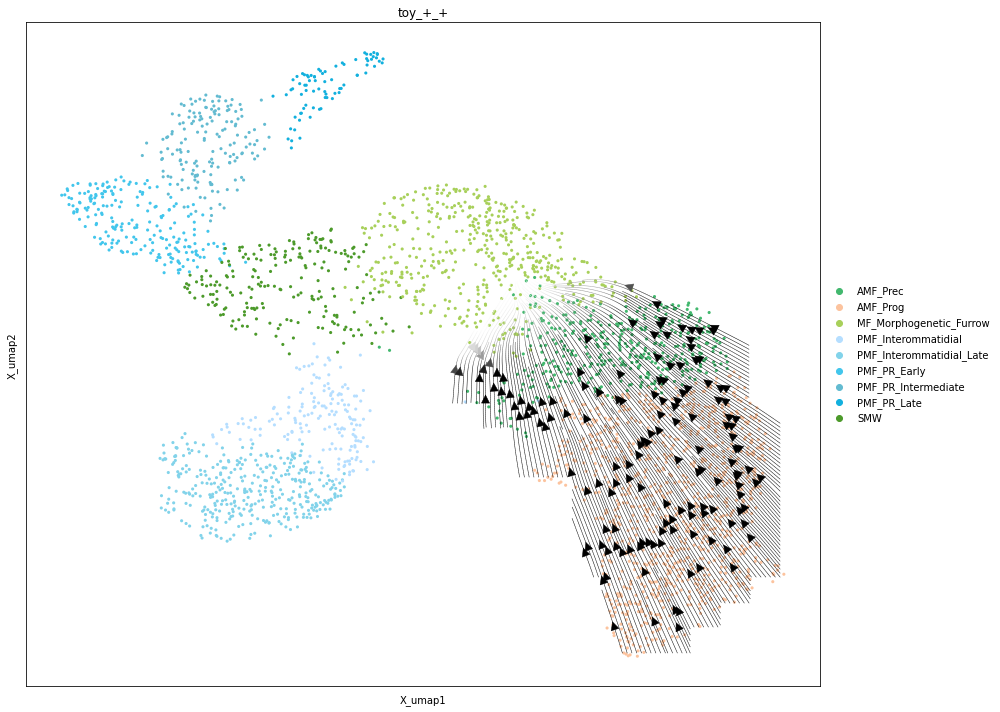

In [77]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'toy_+_+', color_var='Diff_state', n_grid_cols = 25, n_grid_rows = 25, offset_frac = 0.005,
             tf_traj_thr=0.8, tf_expr_thr=0.2, scale=50, figsize=(14,10), gam_smooth=True,  palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/arrow_plots/toy_low_thr.pdf')

## so

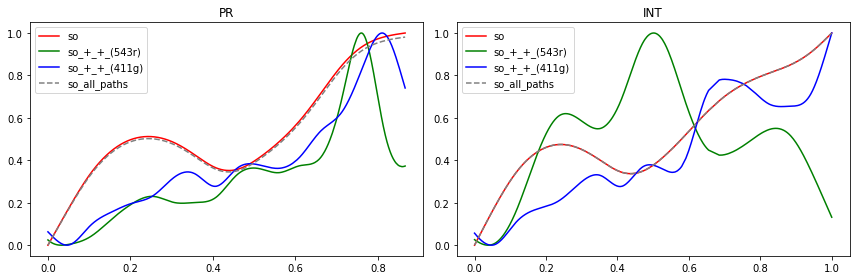

In [78]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'PR', 'so_+_+', window=1, gam_smooth=True, return_data = True)
plt.subplot(1, 2, 2)
df_2 = plot_potential(adata, paths_cascade, 'INT', 'so_+_+', window=1, gam_smooth=True, return_data = True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/curve_plots/so.pdf')

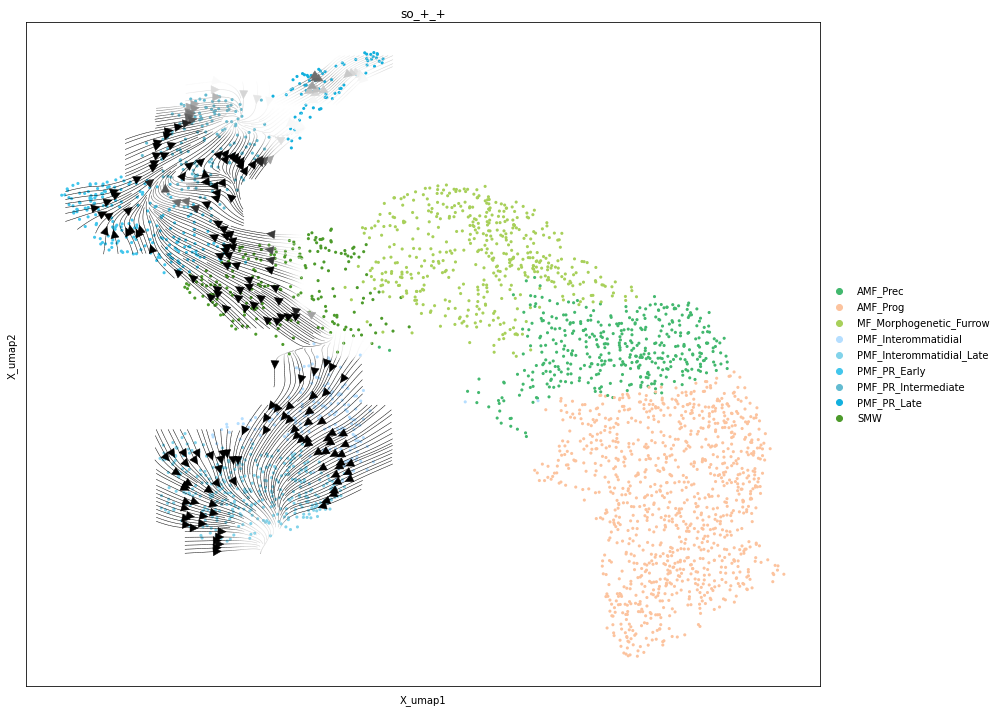

In [79]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'so_+_+', color_var='Diff_state', n_grid_cols = 25, n_grid_rows = 25, offset_frac = 0.005,
             tf_traj_thr=0.7, tf_expr_thr=0.2, scale=50, figsize=(14,10), gam_smooth=True,  palette={
    "AMF_Prog": "#FCC39E",
    "AMF_Prec": "#42B86E",
    "MF_Morphogenetic_Furrow": "#A8D05A",
    "SMW": "#4C9A2A",
    "PMF_Interommatidial": "#B5DEFF",
    "PMF_Interommatidial_Late": "#82D3EA",
    "PMF_PR_Early": "#42C6EC", 
    "PMF_PR_Intermediate": "#63BBD1",
    "PMF_PR_Late": "#12b0de"
}, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/diff_plot/arrow_plots/so_thr.pdf')

### C. Calculate the most relevant forces for a cell

#### I. Calculate forces per cell

In [5]:
# To read
import scanpy as sc
adata = sc.read_h5ad('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/differenrentiation_tutorial_4.h5ad')

In [6]:
# Set paths
paths = [('PR', ['AMF_Prog', 'AMF_Prec', 'MF_Morphogenetic_Furrow', 'SMW_PR', 'PMF_PR_Early', 'PMF_PR_Intermediate', 'PMF_PR_Late']),
         ('INT', ['AMF_Prog', 'AMF_Prec', 'MF_Morphogenetic_Furrow', 'SMW_INT', 'PMF_Interommatidial', 'PMF_Interommatidial_Late'])]

In [7]:
# Calculate path matrices
## Select path features
import os
selected_features = {}
selected_features['TF'] = list(set([x.split('_')[0] for x in adata.var.index.tolist() if 'g)' in x]))
selected_features['Region'] = [x for x in adata.var.index.tolist() if 'r)' in x]
selected_features['Gene'] = [x for x in adata.var.index.tolist() if 'g)' in x]
## Calculate
os.chdir('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/scenicplus/src/scenicplus')
from differentiation_potential import *
paths_cascade = {'TF':{}, 'Region':{}, 'Gene':{}}
for x in paths_cascade.keys():
    for ipath, (descr, path) in enumerate(paths):
        mat= get_path_matrix(
                adata, dpt_var = 'distance',
                path_var = 'clusters',
                path = path, features = selected_features[x],
                split_groups = True)
        paths_cascade[x][descr] = mat

In [6]:
# We will do only for the positives as example
ke = list(paths_cascade[list(paths_cascade.keys())[0]].keys())
selected_eGRNs = [x.split('_(')[0] for x in paths_cascade['Gene'][ke[0]].columns if '+_+' in x]
len(selected_eGRNs)

400

In [ ]:
# Run in a tmux session, check that the server is not too busy
import time
start_time = time.time()
df = cell_forces(adata, paths_cascade, plot_type='tf_to_gene', window=1, gam_smooth=True, tf_traj_thr=0.7, tf_expr_thr=0.2,
               selected_eGRNs=selected_eGRNs, n_cpu=20, _temp_dir='/scratch/leuven/313/vsc31305/ray_spill')
print(time.time() - start_time)
#~10 min

In [10]:
# Save
import dill
with open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/differentiation_tutorial_cell_forces_v2.pkl', 'wb') as f:
    dill.dump(df, f)

#### II. Plot RSS

In [1]:
# Load
import dill
infile = open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/differentiation_tutorial_cell_forces_v2.pkl', 'rb')
df = dill.load(infile)
infile.close()

In [8]:
# We'll filter lowly expressed TFs in this branch
import numpy as np
adata.var['Score'] = np.count_nonzero(adata.X > 1.5, axis=0)

In [9]:
import pandas as pd
subset = pd.read_csv('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/HQ_regulons_only_eye.tsv').iloc[:,0].tolist()
subset = [x.split('_')[0] for x in subset]
s = [x.split('_(')[0] for x in selected_features['Gene'] if '+_+' in x and x.split('_')[0] in subset and x.split('_(')[0] in df.columns and adata.var['Score'].loc[x.split('_')[0]] > 30]

In [10]:
rss_values = forces_rss(adata, df, 'Diff_state_refined')
rss_values = rss_values[s]

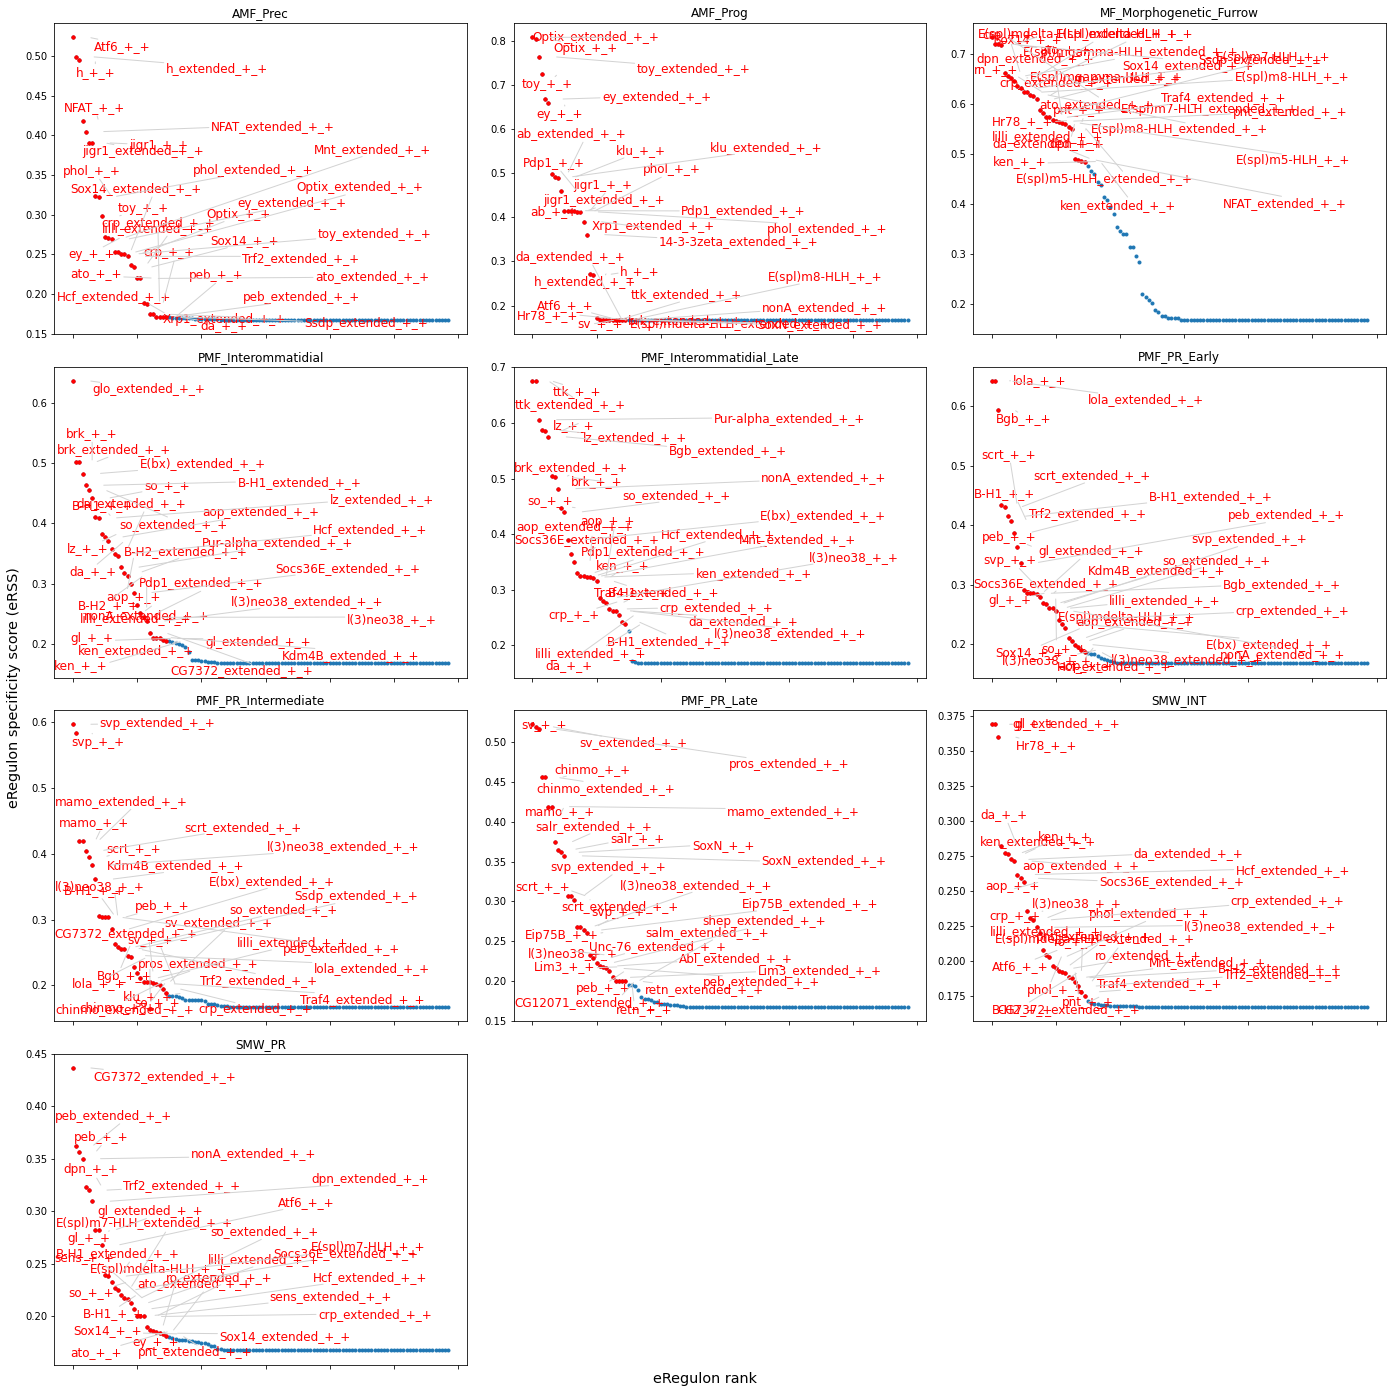

In [11]:
plot_forces_rss(rss_values, top_n=30, num_columns=3)

In [12]:
direct_eRegulons = [x for x in rss_values.columns if not 'extended' in x]
extended_eRegulons =  [x for x in rss_values.columns  if 'extended' in x and not x.replace('_extended', '') in direct_eRegulons]
selected_eRegulons = direct_eRegulons + extended_eRegulons

In [13]:
rss_values = rss_values[selected_eRegulons]

In [14]:
import re
rss_values.columns = [re.sub('_extended', '', file) for file in rss_values.columns]

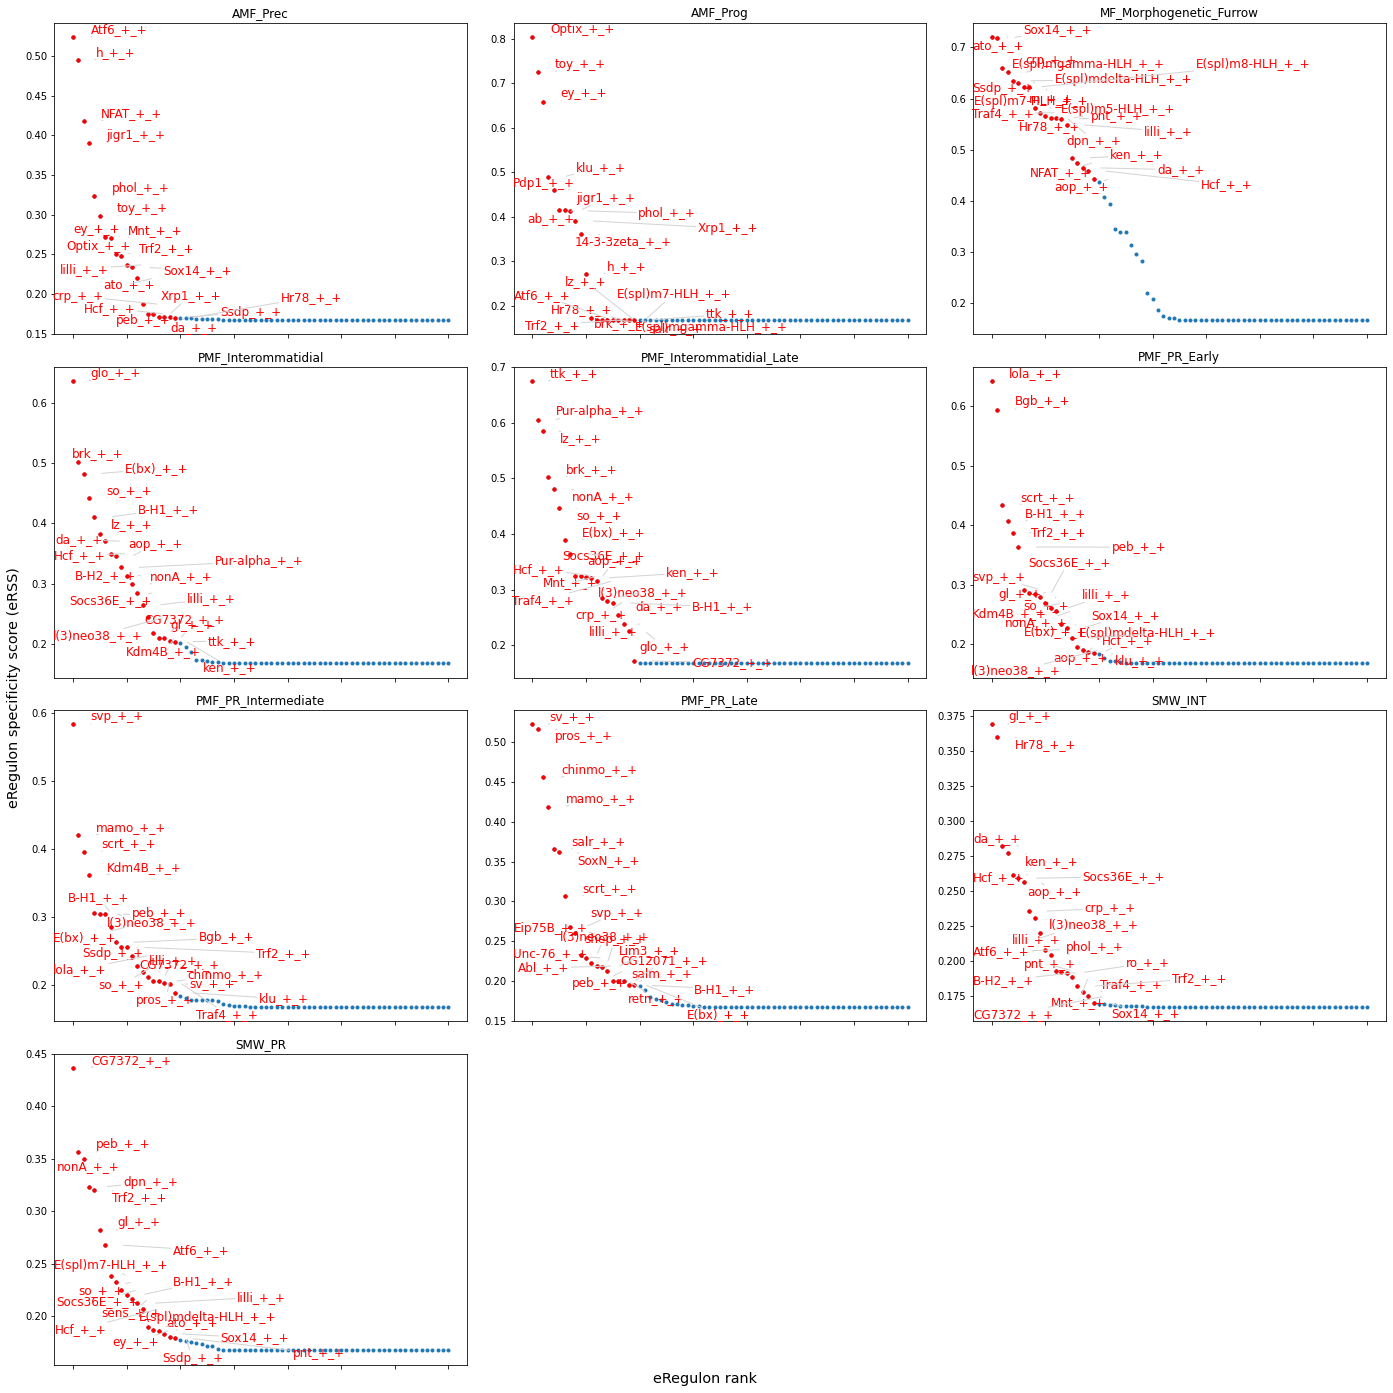

In [15]:
plot_forces_rss(rss_values, top_n=20, num_columns=3)

In [16]:
rss_values = forces_rss(adata, df, 'Diff_state_refined')
direct_eRegulons = [x for x in rss_values.columns if not 'extended' in x]
extended_eRegulons =  [x for x in rss_values.columns  if 'extended' in x and not x.replace('_extended', '') in direct_eRegulons]
selected_eRegulons = direct_eRegulons + extended_eRegulons
import re
rss_values= rss_values[selected_eRegulons]
rss_values.columns = [re.sub('_extended', '', file) for file in rss_values.columns]

In [17]:
selected_eRegulons = ['h', 'Optix', 'toy', 'ey', 'aop', 'sens', 'ato', 'E(spl)mgamma-HLH', 'E(spl)m5-HLH', 'rn', 'lola', 'luna', 'ase', 'gl', 'so', 'l(3)neo38', 'ro', 'salm', 'Pph13', 'bru3', 'nerfin-1', 'svp', 'run', 'chinmo', 'onecut',
                      'retn', 'sv', 'scrt', 'ewg', 'pros', 'mamo', 'lz', 'B-H1', 'B-H2', 'ttk']
selected_eRegulons = [x+'_+_+' for x in selected_eRegulons]

In [18]:
rss_values_2 = rss_values[selected_eRegulons]

In [23]:
rss_values_2.columns = [re.sub('_\+_\+', '(+)', file) for file in rss_values_2.columns]

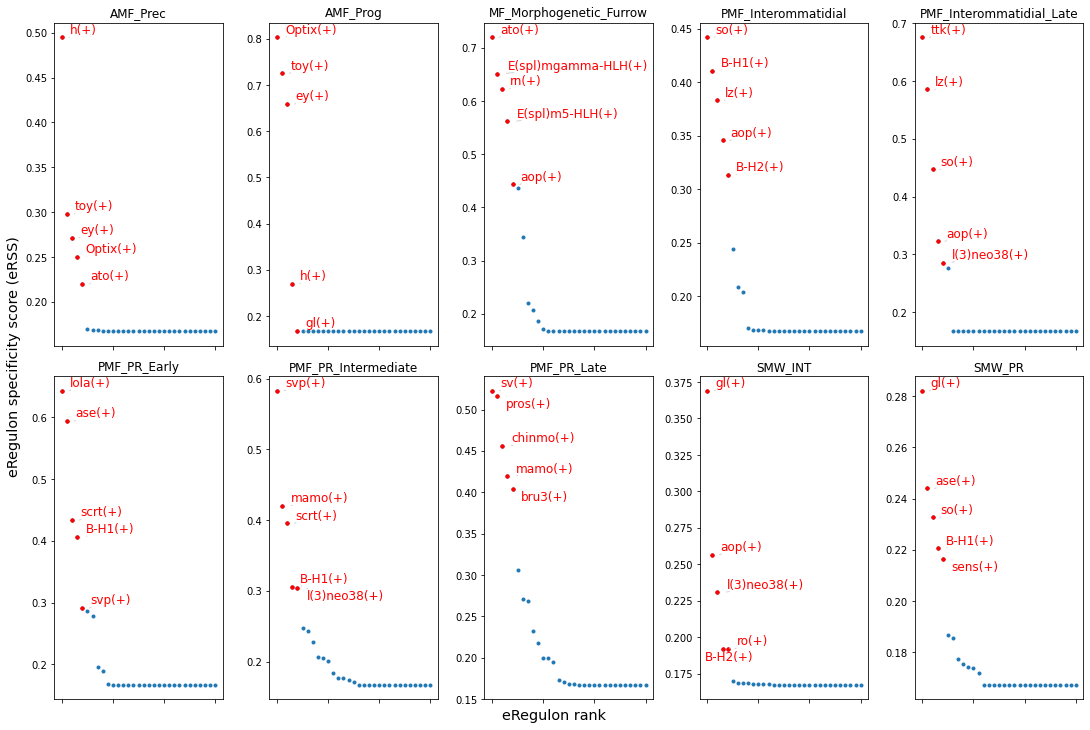

In [25]:
plot_forces_rss(rss_values_2, top_n=5, num_columns=5,  save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/prior_suppl.pdf', figsize = (15, 10))

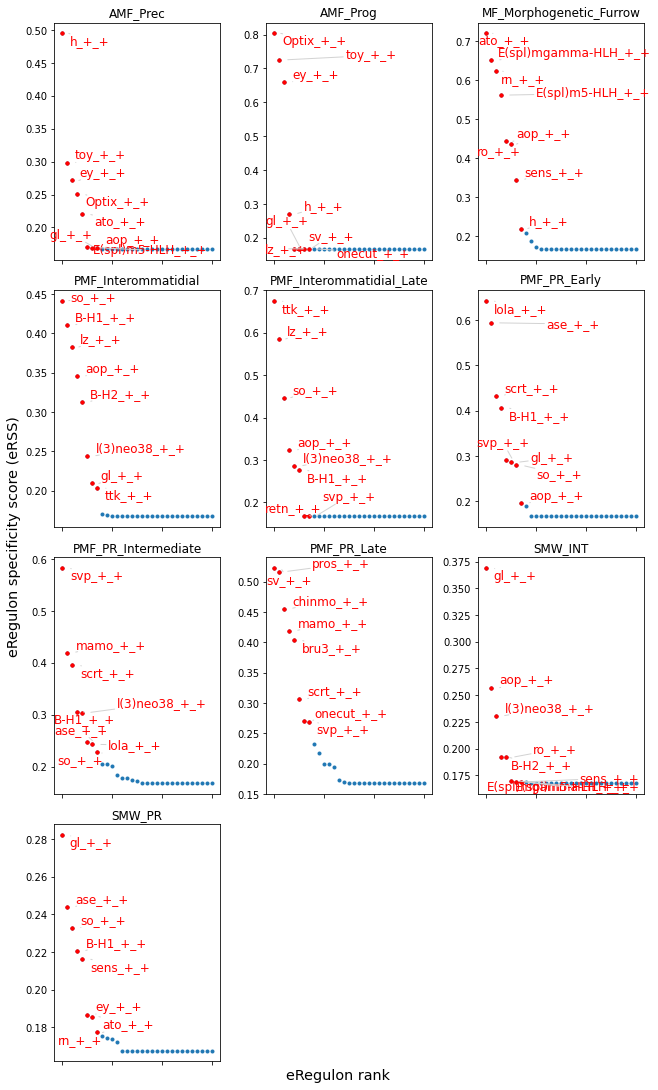

In [137]:
plot_forces_rss(rss_values_2, top_n=8, num_columns=3,  save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/prior_estirado_v2.pdf', figsize = (9, 15))

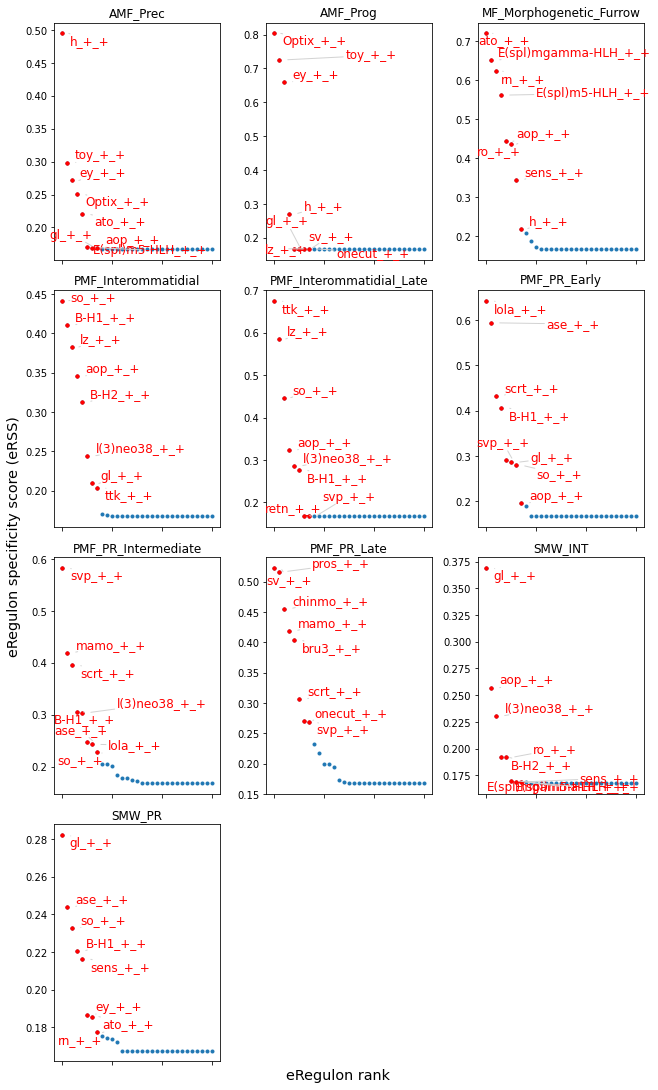

In [137]:
plot_forces_rss(rss_values_2, top_n=8, num_columns=3,  save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/EAD_3/atac/scenicplus_v2/prior_estirado_v2.pdf', figsize = (9, 15))

In [119]:
rss_values = forces_rss(adata, df, 'Diff_state')
direct_eRegulons = [x for x in rss_values.columns if not 'extended' in x]
extended_eRegulons =  [x for x in rss_values.columns  if 'extended' in x and not x.replace('_extended', '') in direct_eRegulons]
selected_eRegulons = direct_eRegulons + extended_eRegulons
import re
rss_values= rss_values[selected_eRegulons]
rss_values.columns = [re.sub('_extended', '', file) for file in rss_values.columns]

In [123]:
selected_eRegulons = ['h', 'Optix', 'toy', 'ey', 'aop', 'sens', 'ato', 'E(spl)mgamma-HLH', 'E(spl)m5-HLH', 'rn', 'lola', 'luna', 'ase', 'gl', 'so', 'l(3)neo38', 'ro', 'salm', 'Pph13', 'bru3', 'nerfin-1', 'svp', 'run', 'chinmo', 'onecut',
                      'retn', 'sv', 'scrt', 'ewg', 'pros', 'mamo', 'lz', 'B-H1', 'B-H2', 'ttk']
selected_eRegulons = [x+'_+_+' for x in selected_eRegulons]

In [124]:
rss_values_2 = rss_values[selected_eRegulons]

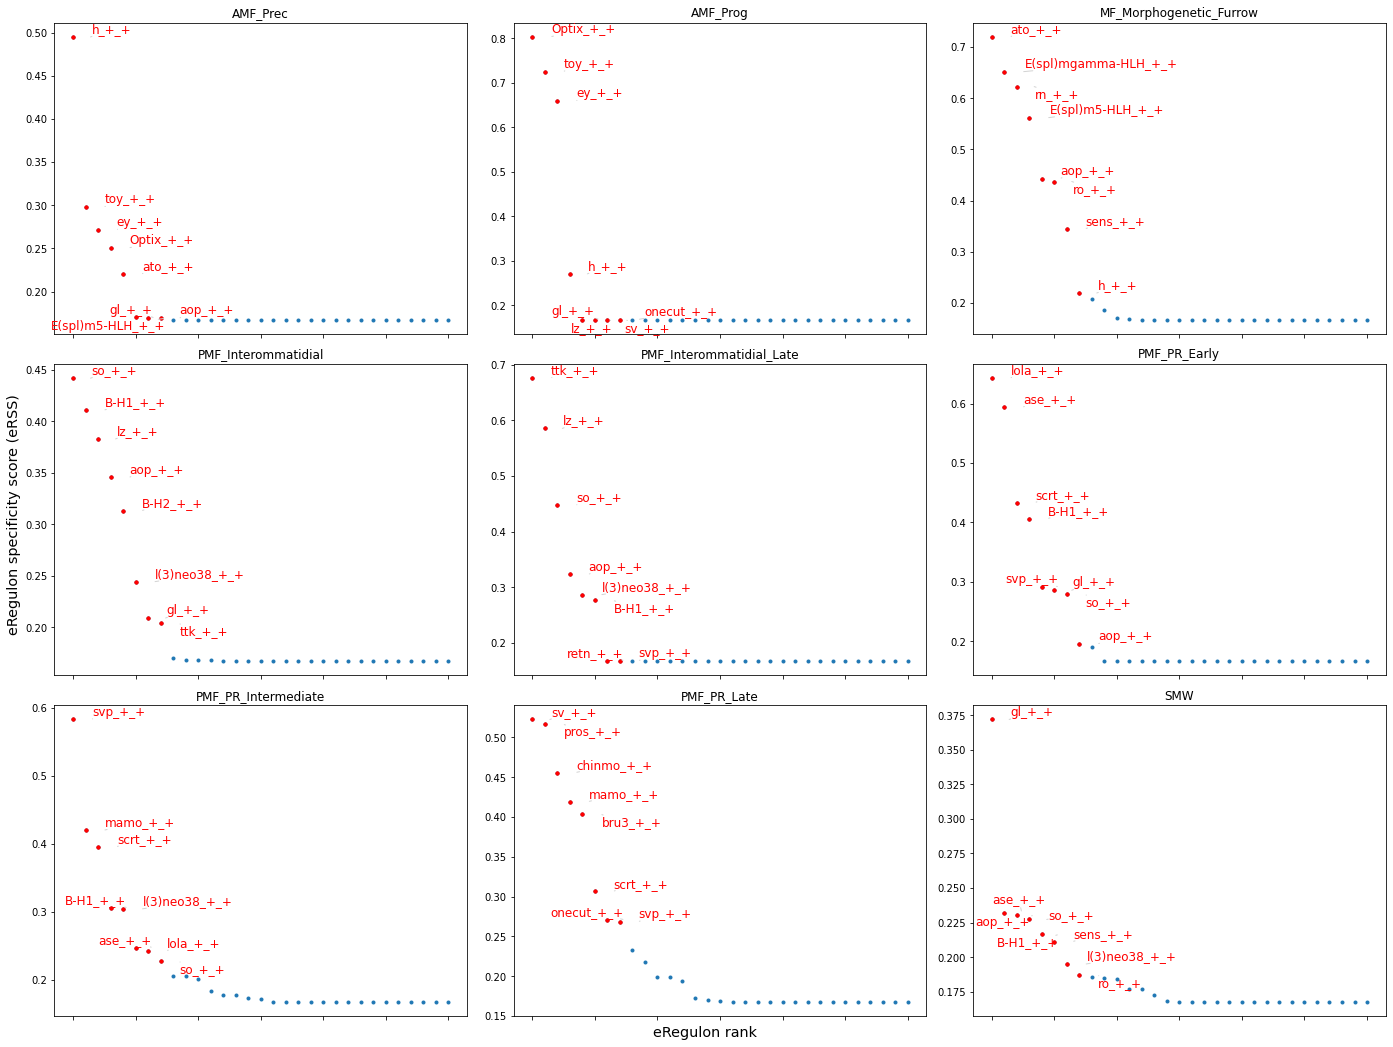

In [125]:
plot_forces_rss(rss_values_2, top_n=8, num_columns=3)